## Libraries

In [1]:
from optbinning import OptimalBinning
from loan_data.preprocess_functions import preprocess
from init_char_analysis import *
import numpy as np
import glob
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score    
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
import pickle

(CVXPY) Nov 27 05:01:14 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 27 05:01:14 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:

mpl.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.size': 11,  # General font size
    'axes.titlesize': 12,  # Title font size
    'axes.labelsize': 11,  # Label font size
    'xtick.labelsize': 10,  # X-axis tick font size
    'ytick.labelsize': 10,  # Y-axis tick font size
    'legend.fontsize': 10,  # Legend font size
    'figure.dpi': 300,  # Higher resolution for reports
    'savefig.dpi': 300,  # Resolution for saved figures
})


## Read in csv's

In [3]:
path = "../../dataset/"
files = glob.glob(path + "/*.csv") 
processed_df = []
for file in files:
    if file != "../../dataset/2021_stat.csv":
        continue 
    print(file)
    temp_data = pd.read_csv(file)
    processed_df.append(temp_data)
    del temp_data
processed_df = pd.concat(processed_df)

../../dataset/2021_stat.csv


In [4]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG',
       'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV'],
      dtype='object')

# Undo one-hot encoding & filter relevant columns

In [5]:
ONE_HOT_ENCODED_MAP = {
    "PUR": ['PUR_Cash_out','PUR_Refinance', 'PUR_Purchase'],
    "PRO": ['PRO_Condominium', 'PRO_Co_operative','PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family'],
    "MI": ['MI_Borrower', 'MI_Lender', 'MI_Investor'],
    "OCC": ['OCC_Principal', 'OCC_Second', 'OCC_Investor']
}

for new_col, cols in ONE_HOT_ENCODED_MAP.items():
    indices = processed_df[cols].to_numpy().argmax(axis=1)
    categories = [col.split('_', 1)[1] for col in cols]  # Extract category names
    processed_df[new_col] = np.array(categories)[indices] 
    processed_df.drop(columns=cols, inplace=True)

processed_df

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,...,Deed_In_Lieu,Non_Performing_NS,Reperforming_NS,COMPLETE_FLAG,NET_LOSS,NET_SEV,PUR,PRO,MI,OCC
0,122128311,2.12,619000.0,180,69.0,1,48.0,798.0,798.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
1,122128312,2.62,636000.0,360,80.0,2,33.0,792.0,793.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
2,122128313,2.62,589000.0,180,60.0,2,22.0,773.0,748.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Planned_Urban,Borrower,Principal
3,122128314,2.75,715000.0,360,92.0,1,35.0,801.0,801.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
4,122128315,2.62,750000.0,360,29.0,2,30.0,793.0,684.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782087,129937967,2.50,160000.0,360,62.0,1,17.0,803.0,803.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
4782088,129937968,2.99,450000.0,360,90.0,1,36.0,740.0,740.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Condominium,Borrower,Principal
4782089,129937969,2.50,153000.0,180,70.0,2,31.0,770.0,724.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
4782090,129937970,2.50,250000.0,180,51.0,2,40.0,755.0,711.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Planned_Urban,Borrower,Principal


In [6]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'STATE', 'ZIP',
       'MSA', 'MI_PCT', 'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE',
       'LAST_UPB', 'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG',
       'DLQ_90_FLAG', 'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ',
       'Prepaid_Matured', 'Third_Party_Sale', 'Short_Sale', 'Repurchased',
       'Deed_In_Lieu', 'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG',
       'NET_LOSS', 'NET_SEV', 'PUR', 'PRO', 'MI', 'OCC'],
      dtype='object')

In [7]:
processed_df = processed_df[(processed_df['DLQ_90_FLAG'] == 1) | (processed_df['DLQ_90_FLAG'] == 0) & (processed_df['Ongoing'] == 1)]

RELEVANT_COLUMNS = [
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
    'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'MI_PCT', 
    'DLQ_90_FLAG', 'PUR', 'PRO', 'MI', 'OCC'
]
processed_df = processed_df[RELEVANT_COLUMNS]

## WOE on Categorical Variables

In [8]:
CAT_COLUMNS = [
    'PUR',
    'PRO',
    'OCC',
    'MI',
    'FTHB_FLAG'  # not sure if this should be here
]

COLUMN: PUR
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Refinance],1841402,0.441846,1826242,15160,0.008233,0.500898,0.087670,1.084560e-02
1,[Cash_out],1026004,0.246190,1012074,13930,0.013577,-0.004745,0.000006,6.943522e-07
2,[Purchase],1300115,0.311964,1272887,27228,0.020943,-0.44566,0.077480,9.605641e-03
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.165156,2.045193e-02


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.21746152
    IV (Jeffrey)             0.16515552
    JS (Jensen-Shannon)      0.02045193
    Hellinger                0.02054764
    Triangular               0.08105497
    KS                       0.17502540
    HHI                      0.35315885
    HHI (normalized)         0.19144856
    Cramer's V               0.04707369
    Quality score            0.50994014

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  1873.827253      0.0       0.0       1.0
        1      2  1790.076625      0.0       0.0       1.0

None


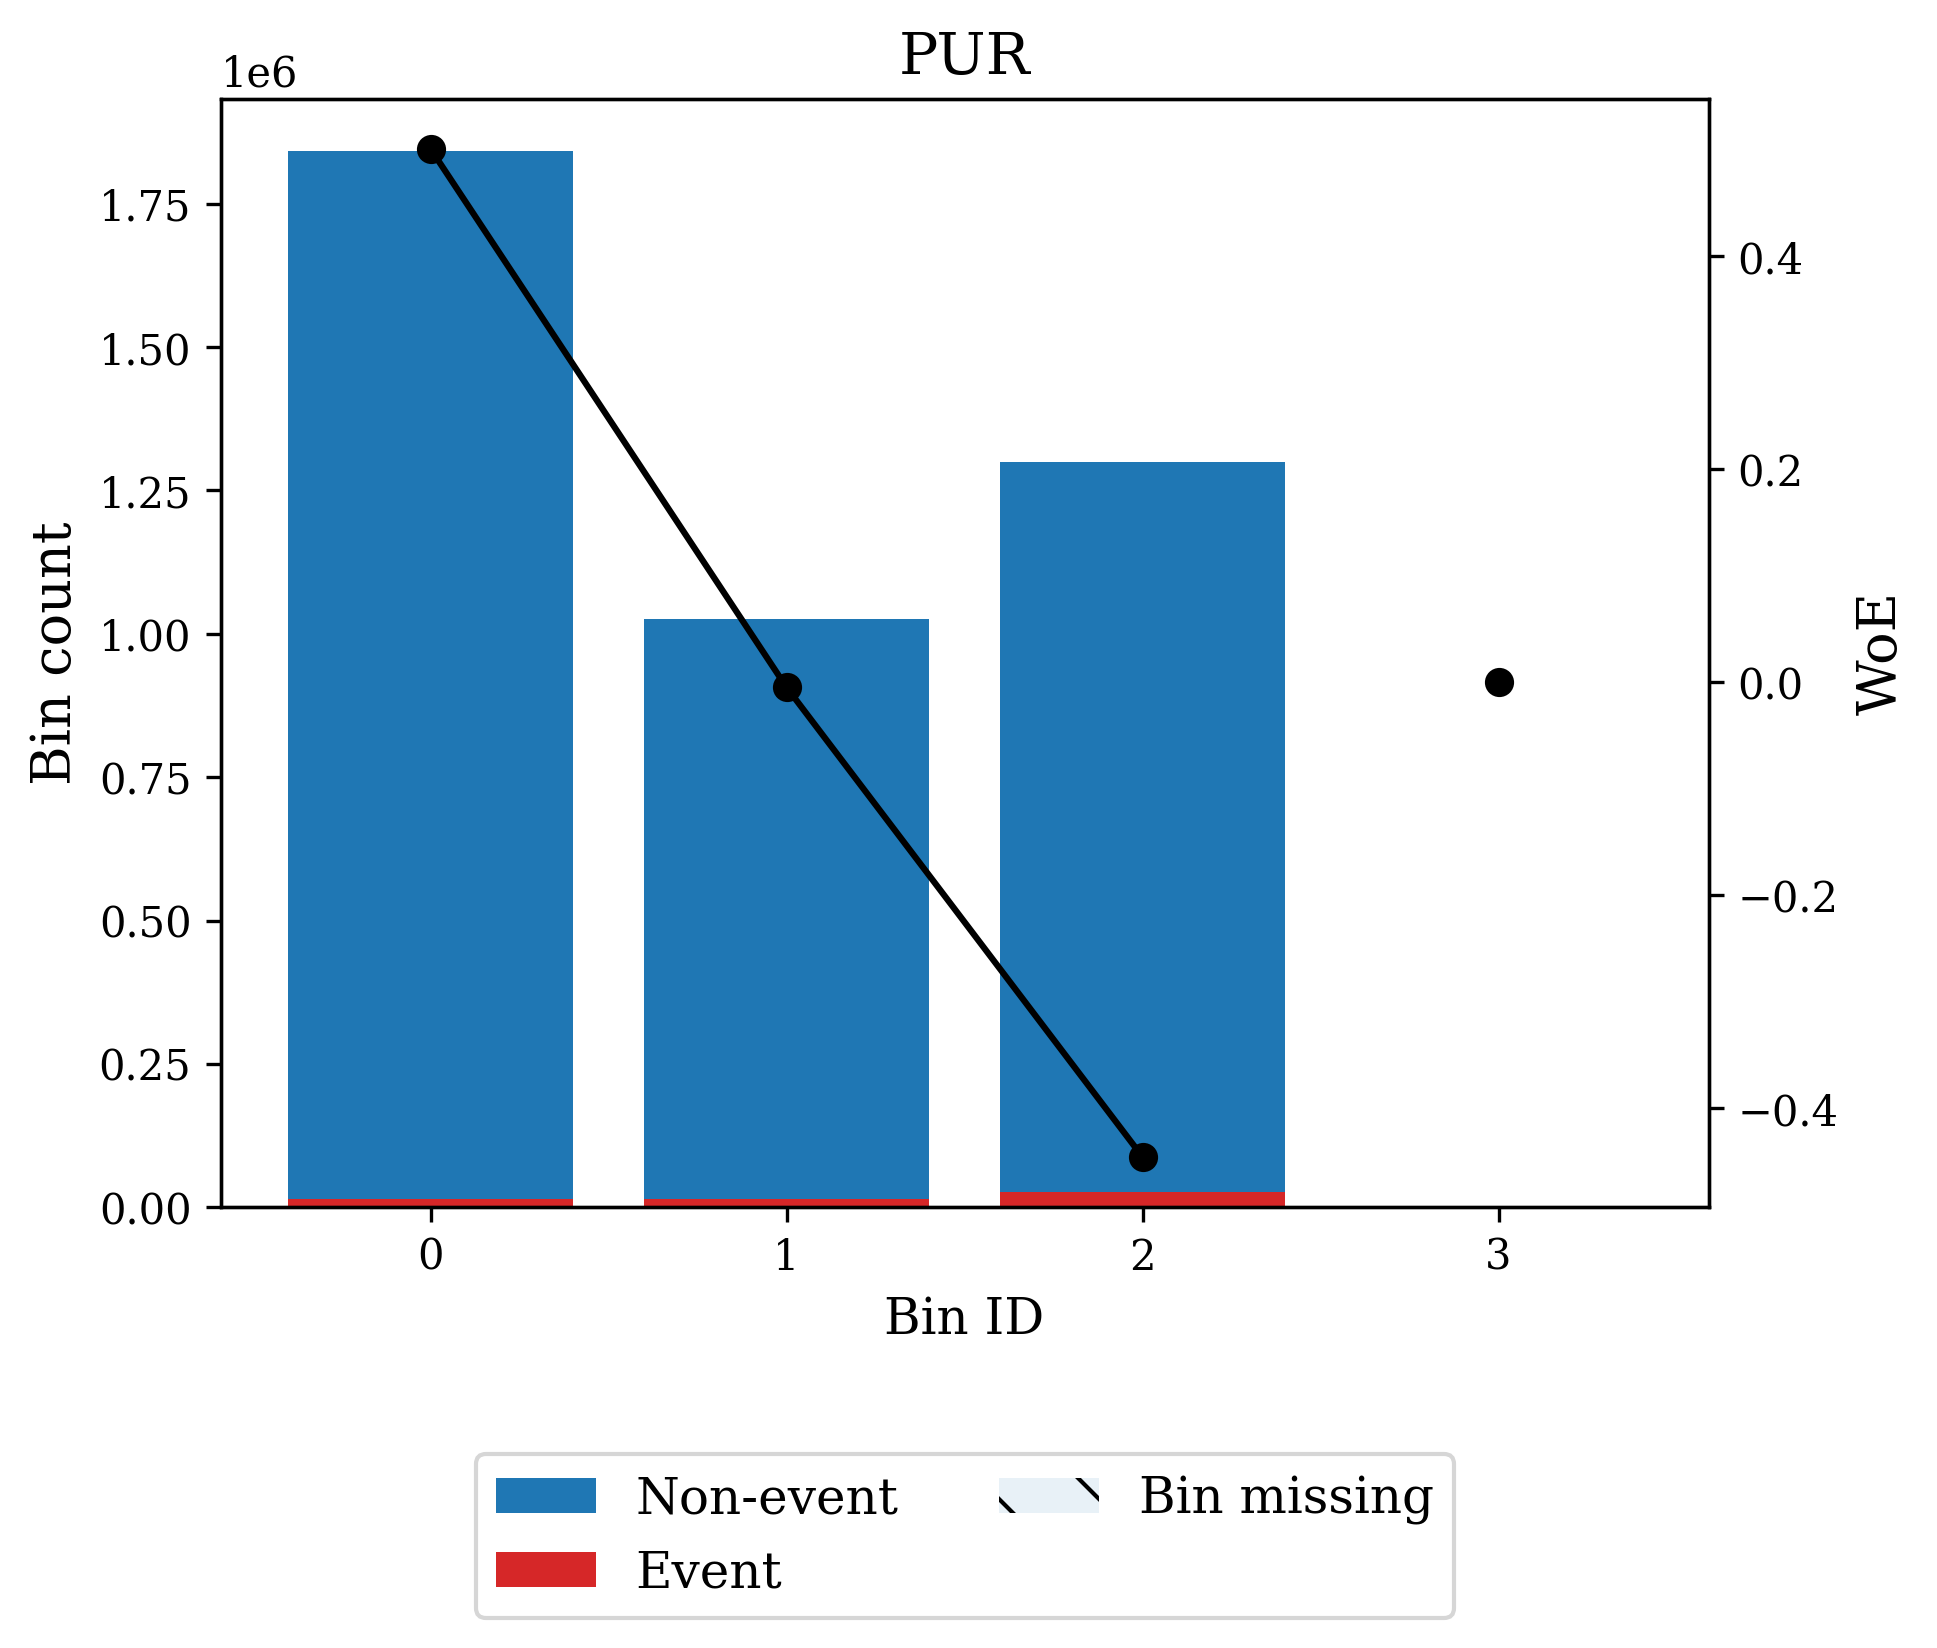


COLUMN: PRO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Co_operative, Condominium]",385579,0.092520,381088,4491,0.011647,0.150498,0.001949,0.000243
1,[Planned_Urban],1107540,0.265755,1092805,14735,0.013304,0.015821,0.000066,0.000008
2,"[Single_Family, Manufact_Home]",2674402,0.641725,2637310,37092,0.013869,-0.026343,0.000451,0.000056
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.002466,0.000308


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02017953
    IV (Jeffrey)             0.00246626
    JS (Jensen-Shannon)      0.00030805
    Hellinger                0.00030817
    Triangular               0.00123128
    KS                       0.01712364
    HHI                      0.49099657
    HHI (normalized)         0.36374572
    Cramer's V               0.00557973
    Quality score            0.00653722

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    61.769511 3.861067e-15 9.594145e-17  1.000000
        1      2    18.498357 1.700509e-05 6.094991e-06  0.999994

None


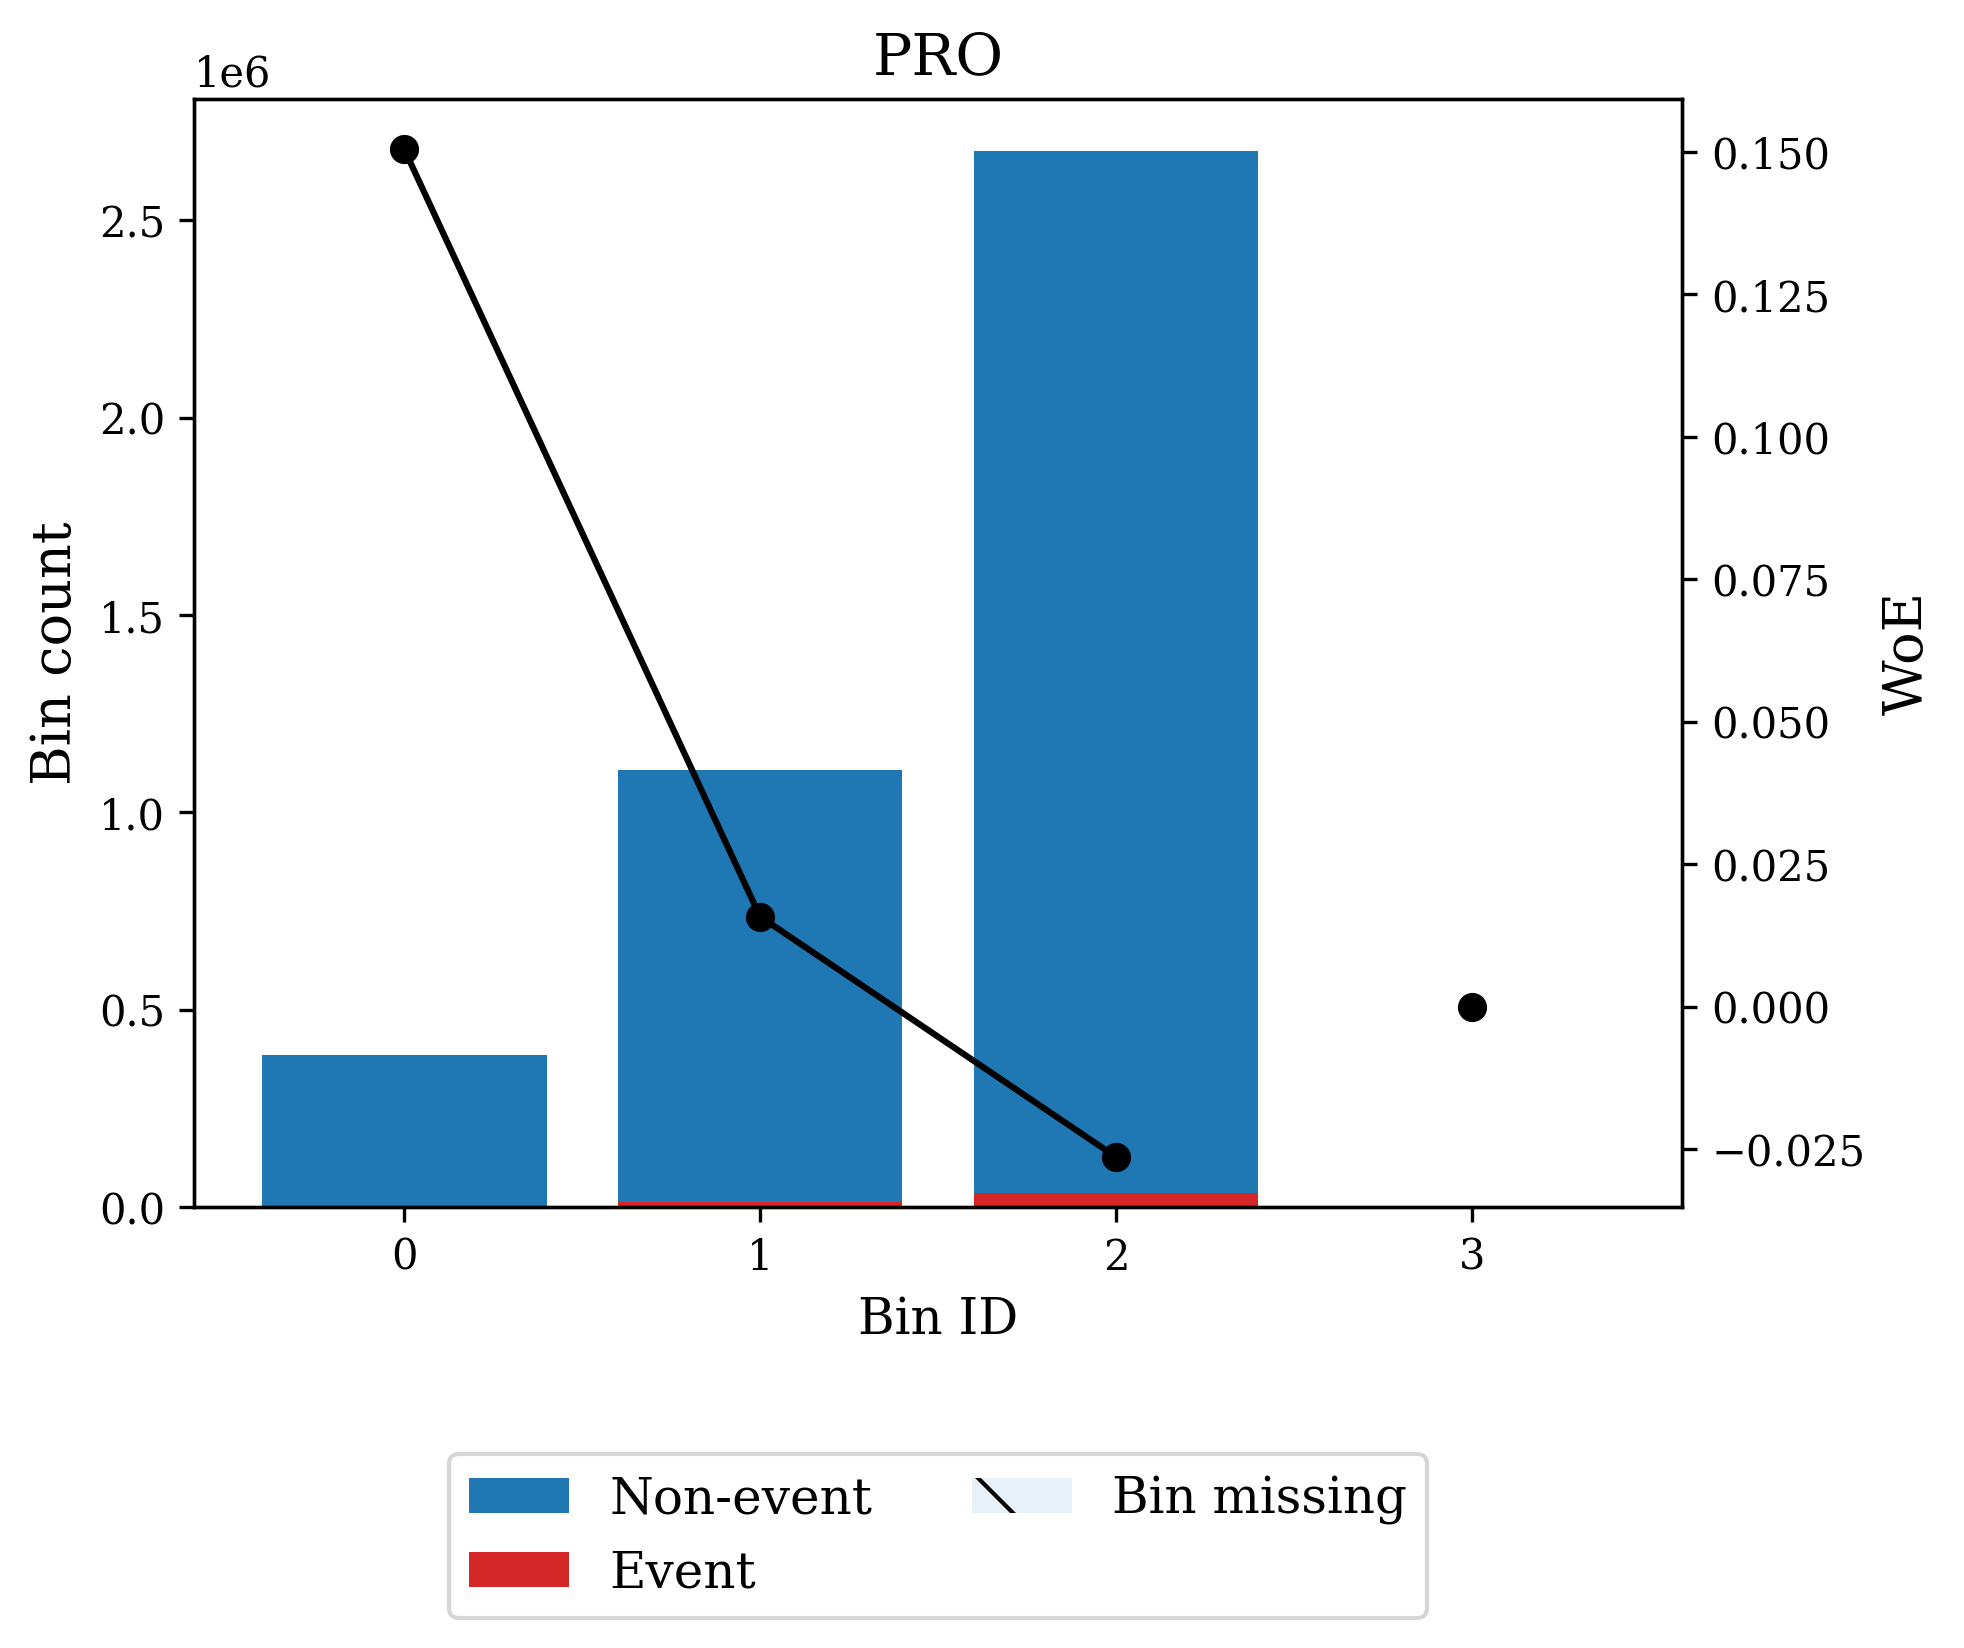


COLUMN: OCC
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Investor, Second]",351848,0.084426,349177,2671,0.007591,0.582669,0.021854,0.002694
1,[Principal],3815673,0.915574,3762026,53647,0.014060,-0.040169,0.001507,0.000188
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.023360,0.002882


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.03750594
    IV (Jeffrey)             0.02336015
    JS (Jensen-Shannon)      0.00288201
    Hellinger                0.00290085
    Triangular               0.01138098
    KS                       0.03750594
    HHI                      0.84540315
    HHI (normalized)         0.79387087
    Cramer's V               0.01557561
    Quality score            0.02002612

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1  1011.038634 7.159418e-222 1.655718e-270       1.0

None


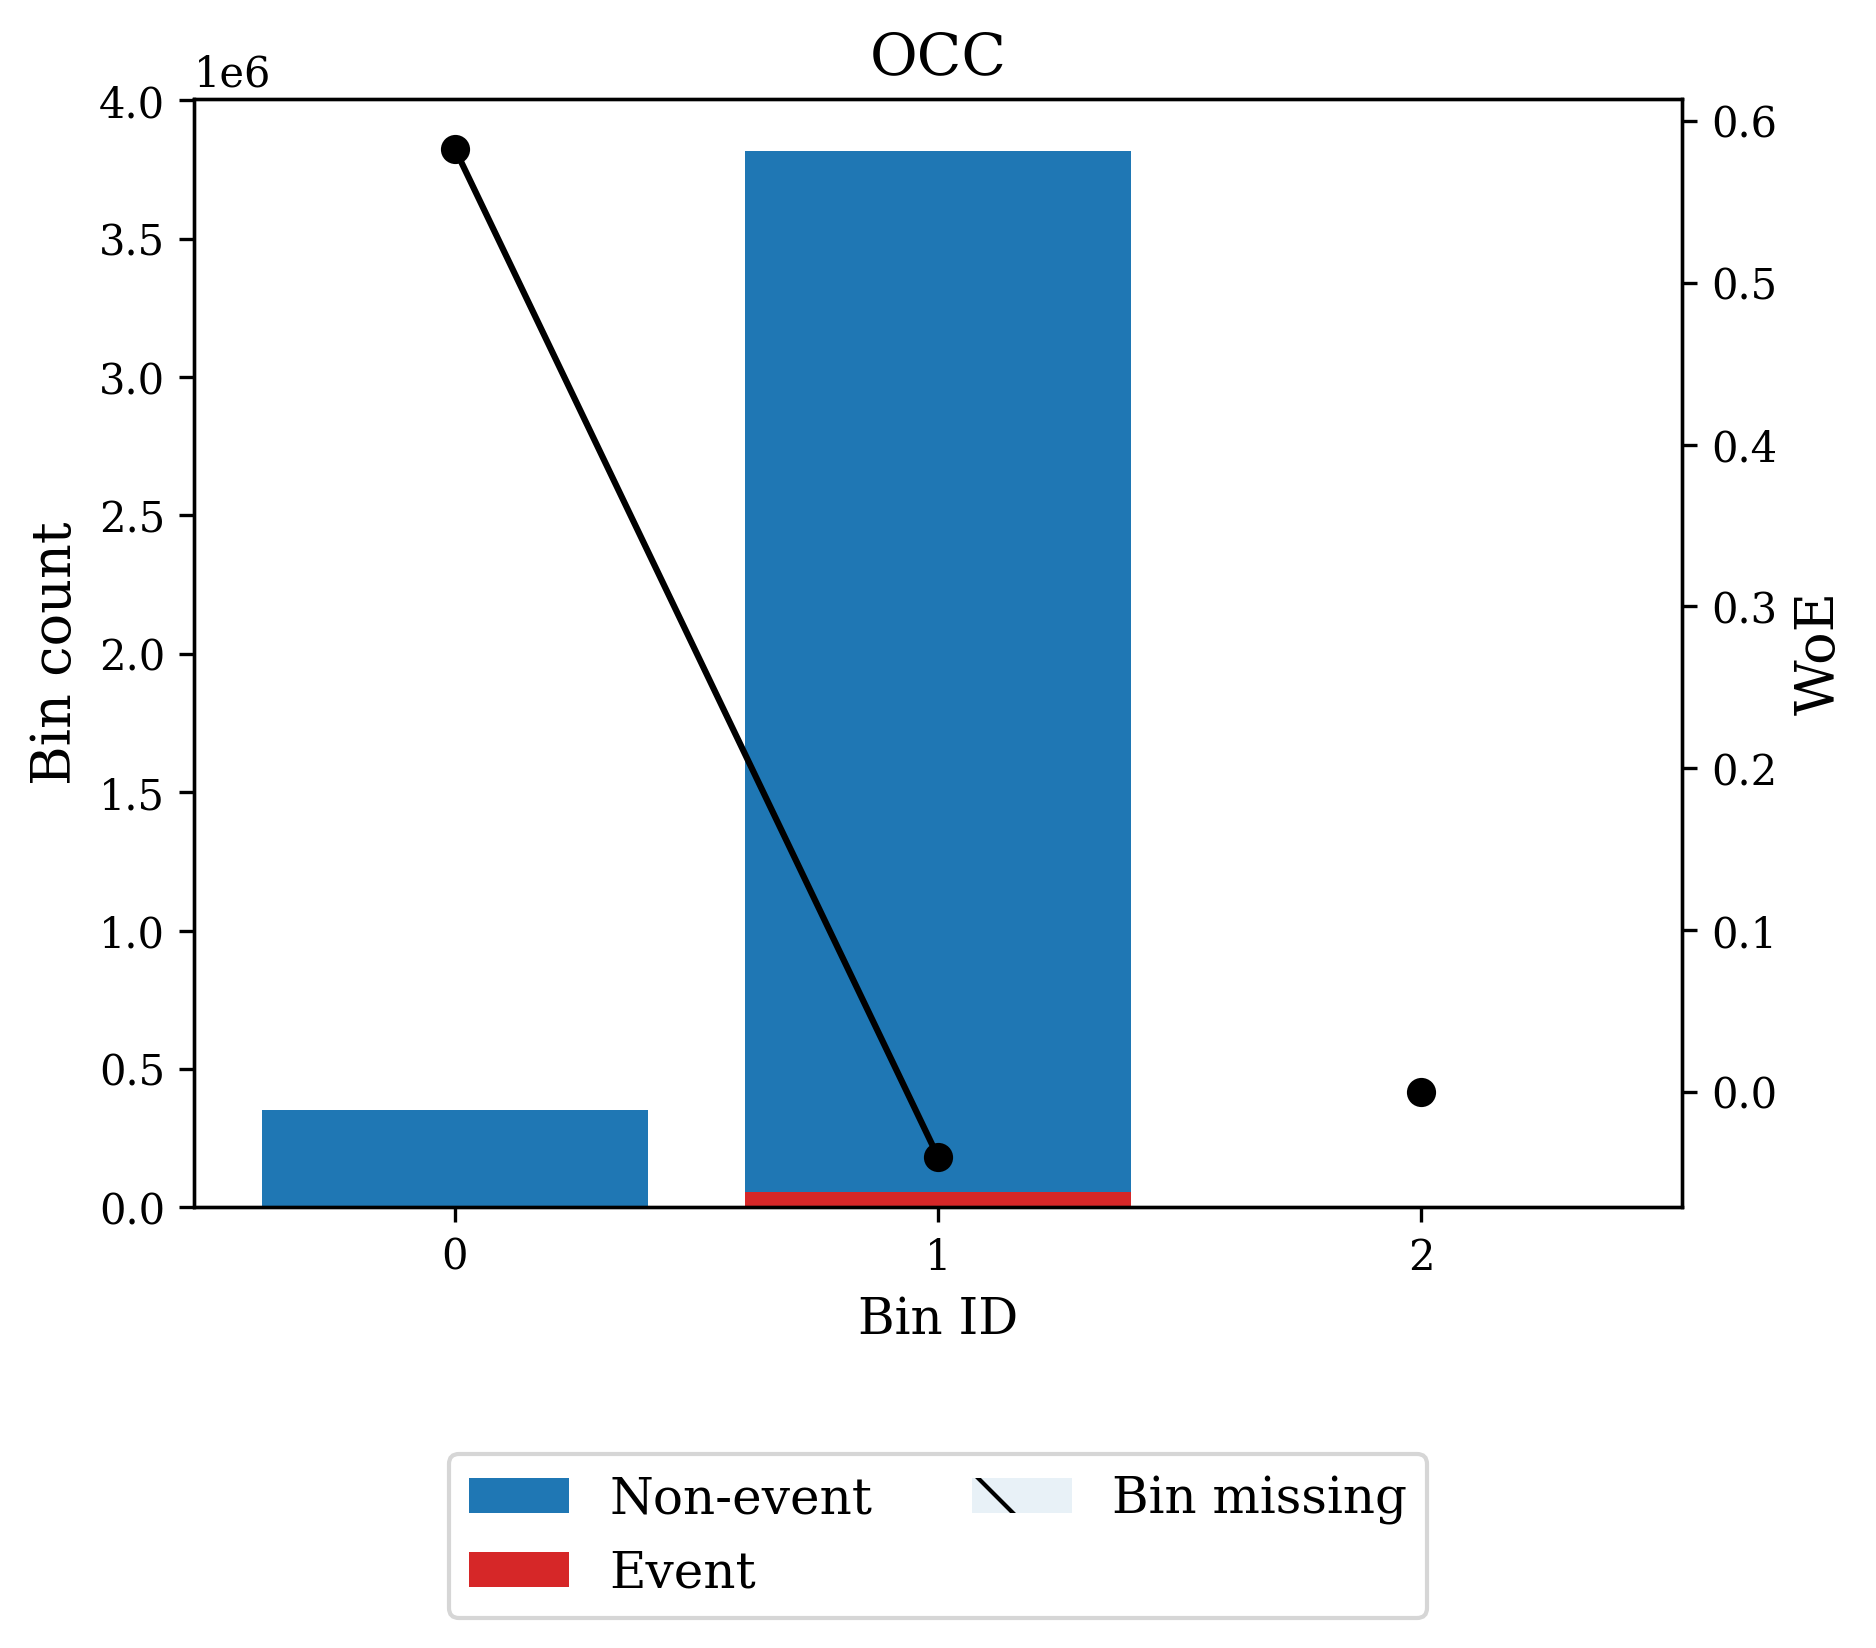


COLUMN: MI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Borrower, Investor, Lender]",4167521,1.0,4111203,56318,0.013514,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,4167521,1.0,4111203,56318,0.013514,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


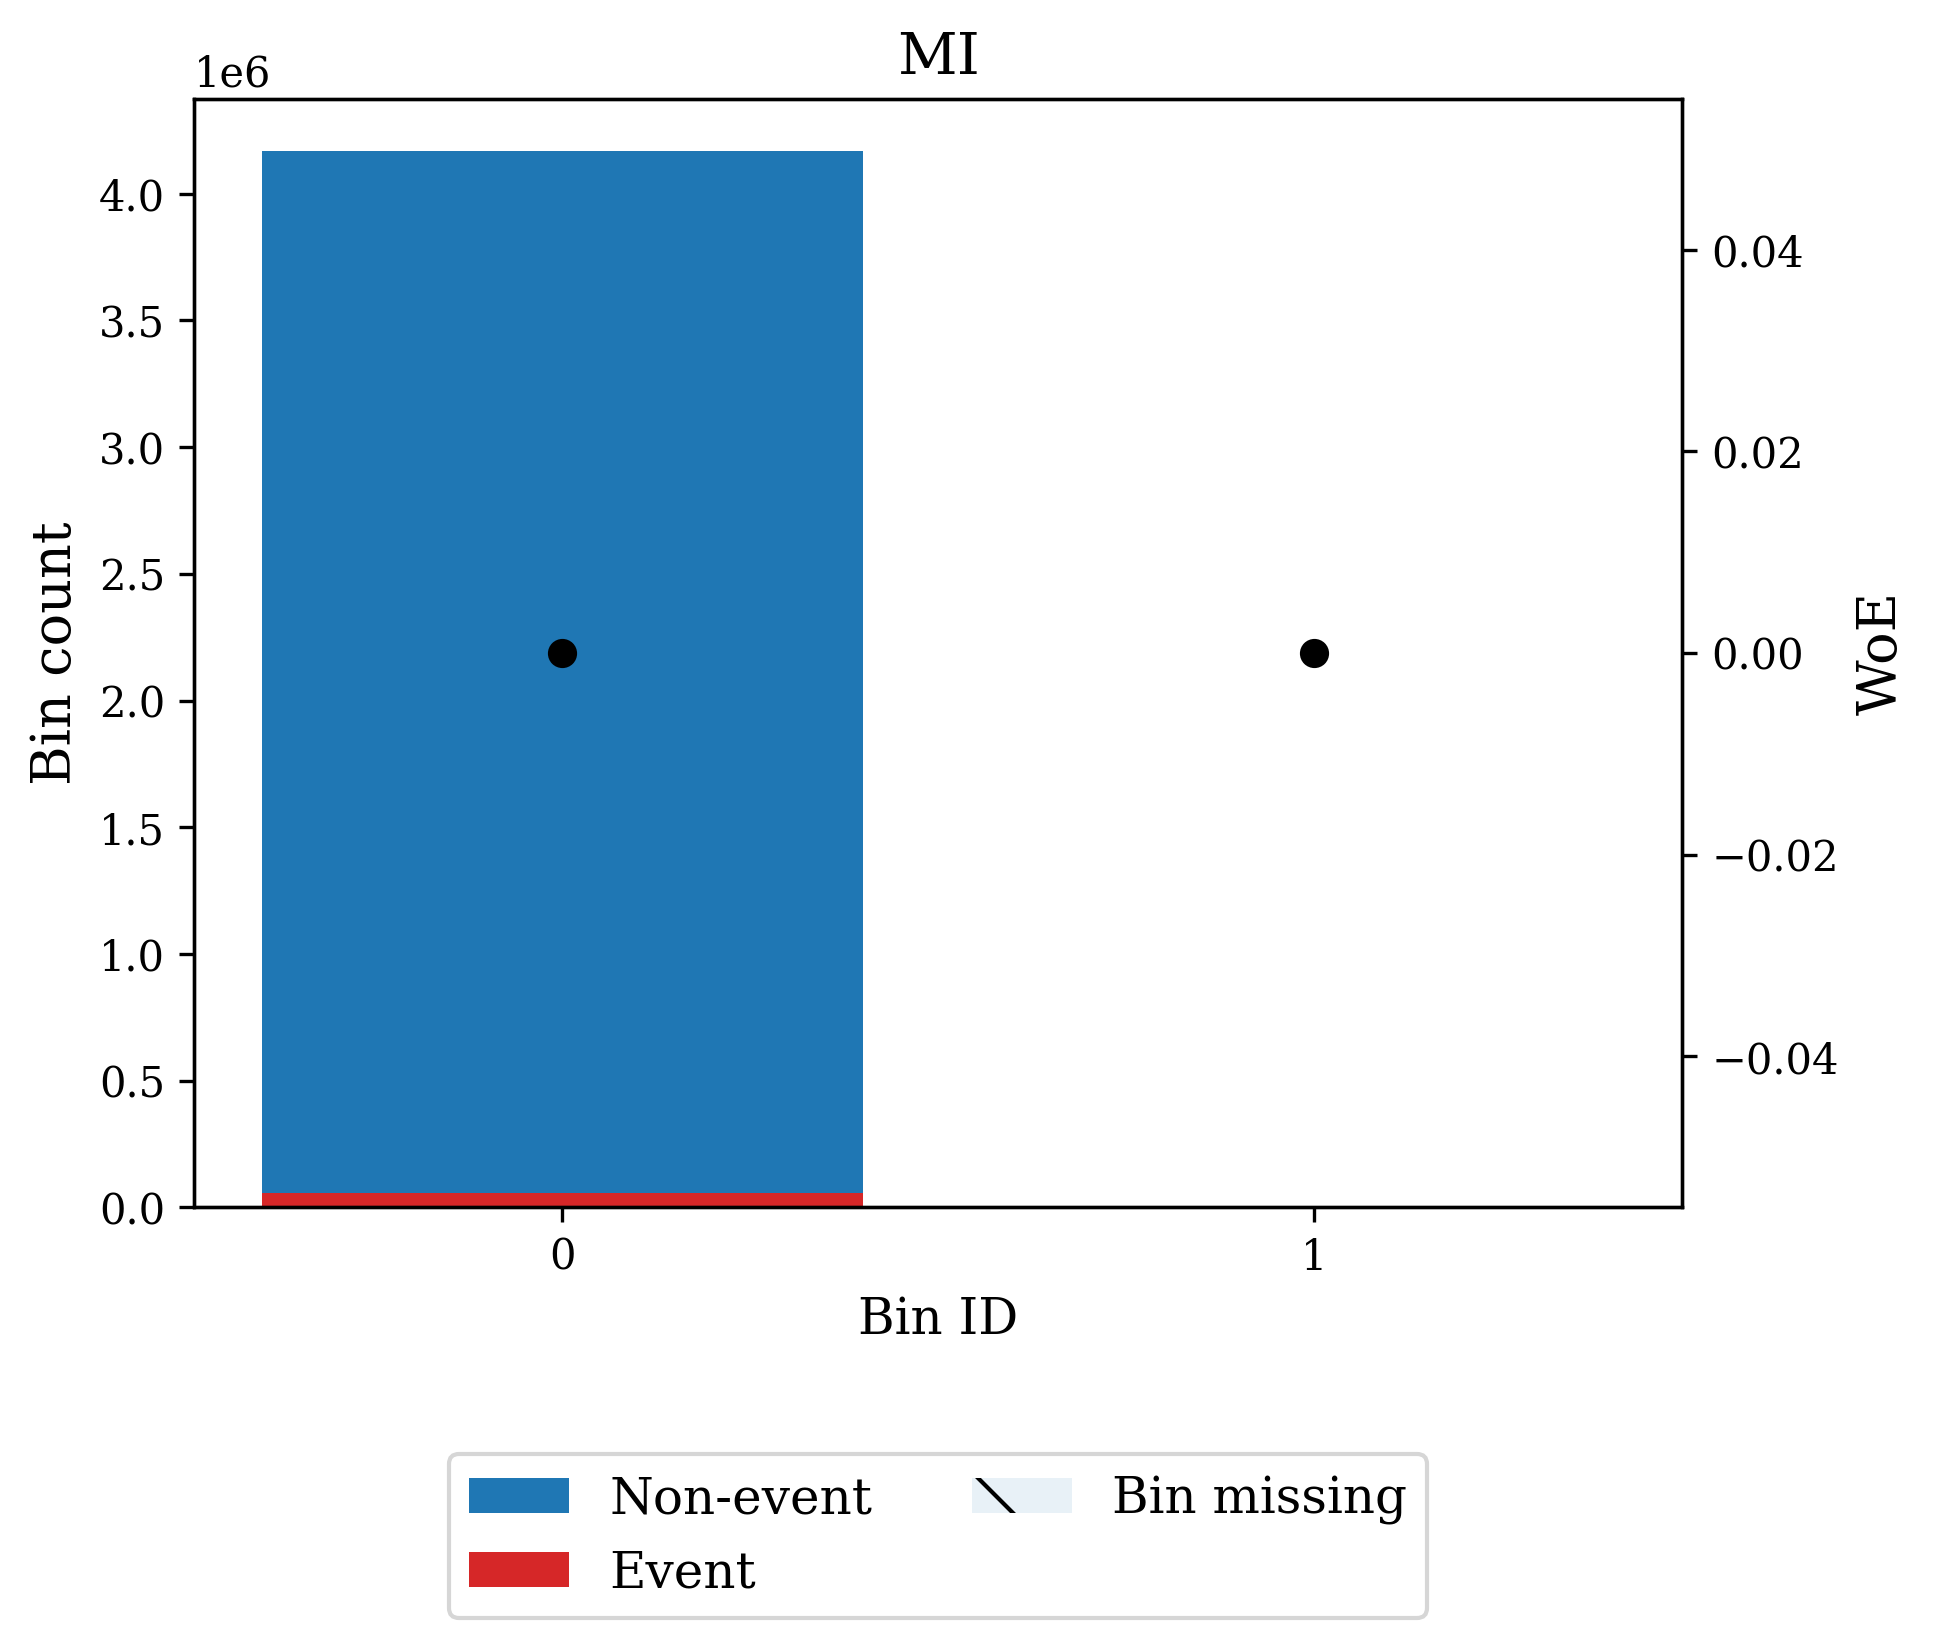


COLUMN: FTHB_FLAG
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],3522242,0.845165,3482135,40107,0.011387,0.173393,0.023379,0.002919
1,[1],645279,0.154835,629068,16211,0.025122,-0.631907,0.085203,0.010477
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.108582,0.013395


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13483446
    IV (Jeffrey)             0.10858228
    JS (Jensen-Shannon)      0.01339540
    Hellinger                0.01348323
    Triangular               0.05289876
    KS                       0.13483446
    HHI                      0.73827746
    HHI (normalized)         0.65103661
    Cramer's V               0.04303538
    Quality score            0.15203017

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  7718.430802      0.0       0.0       1.0

None


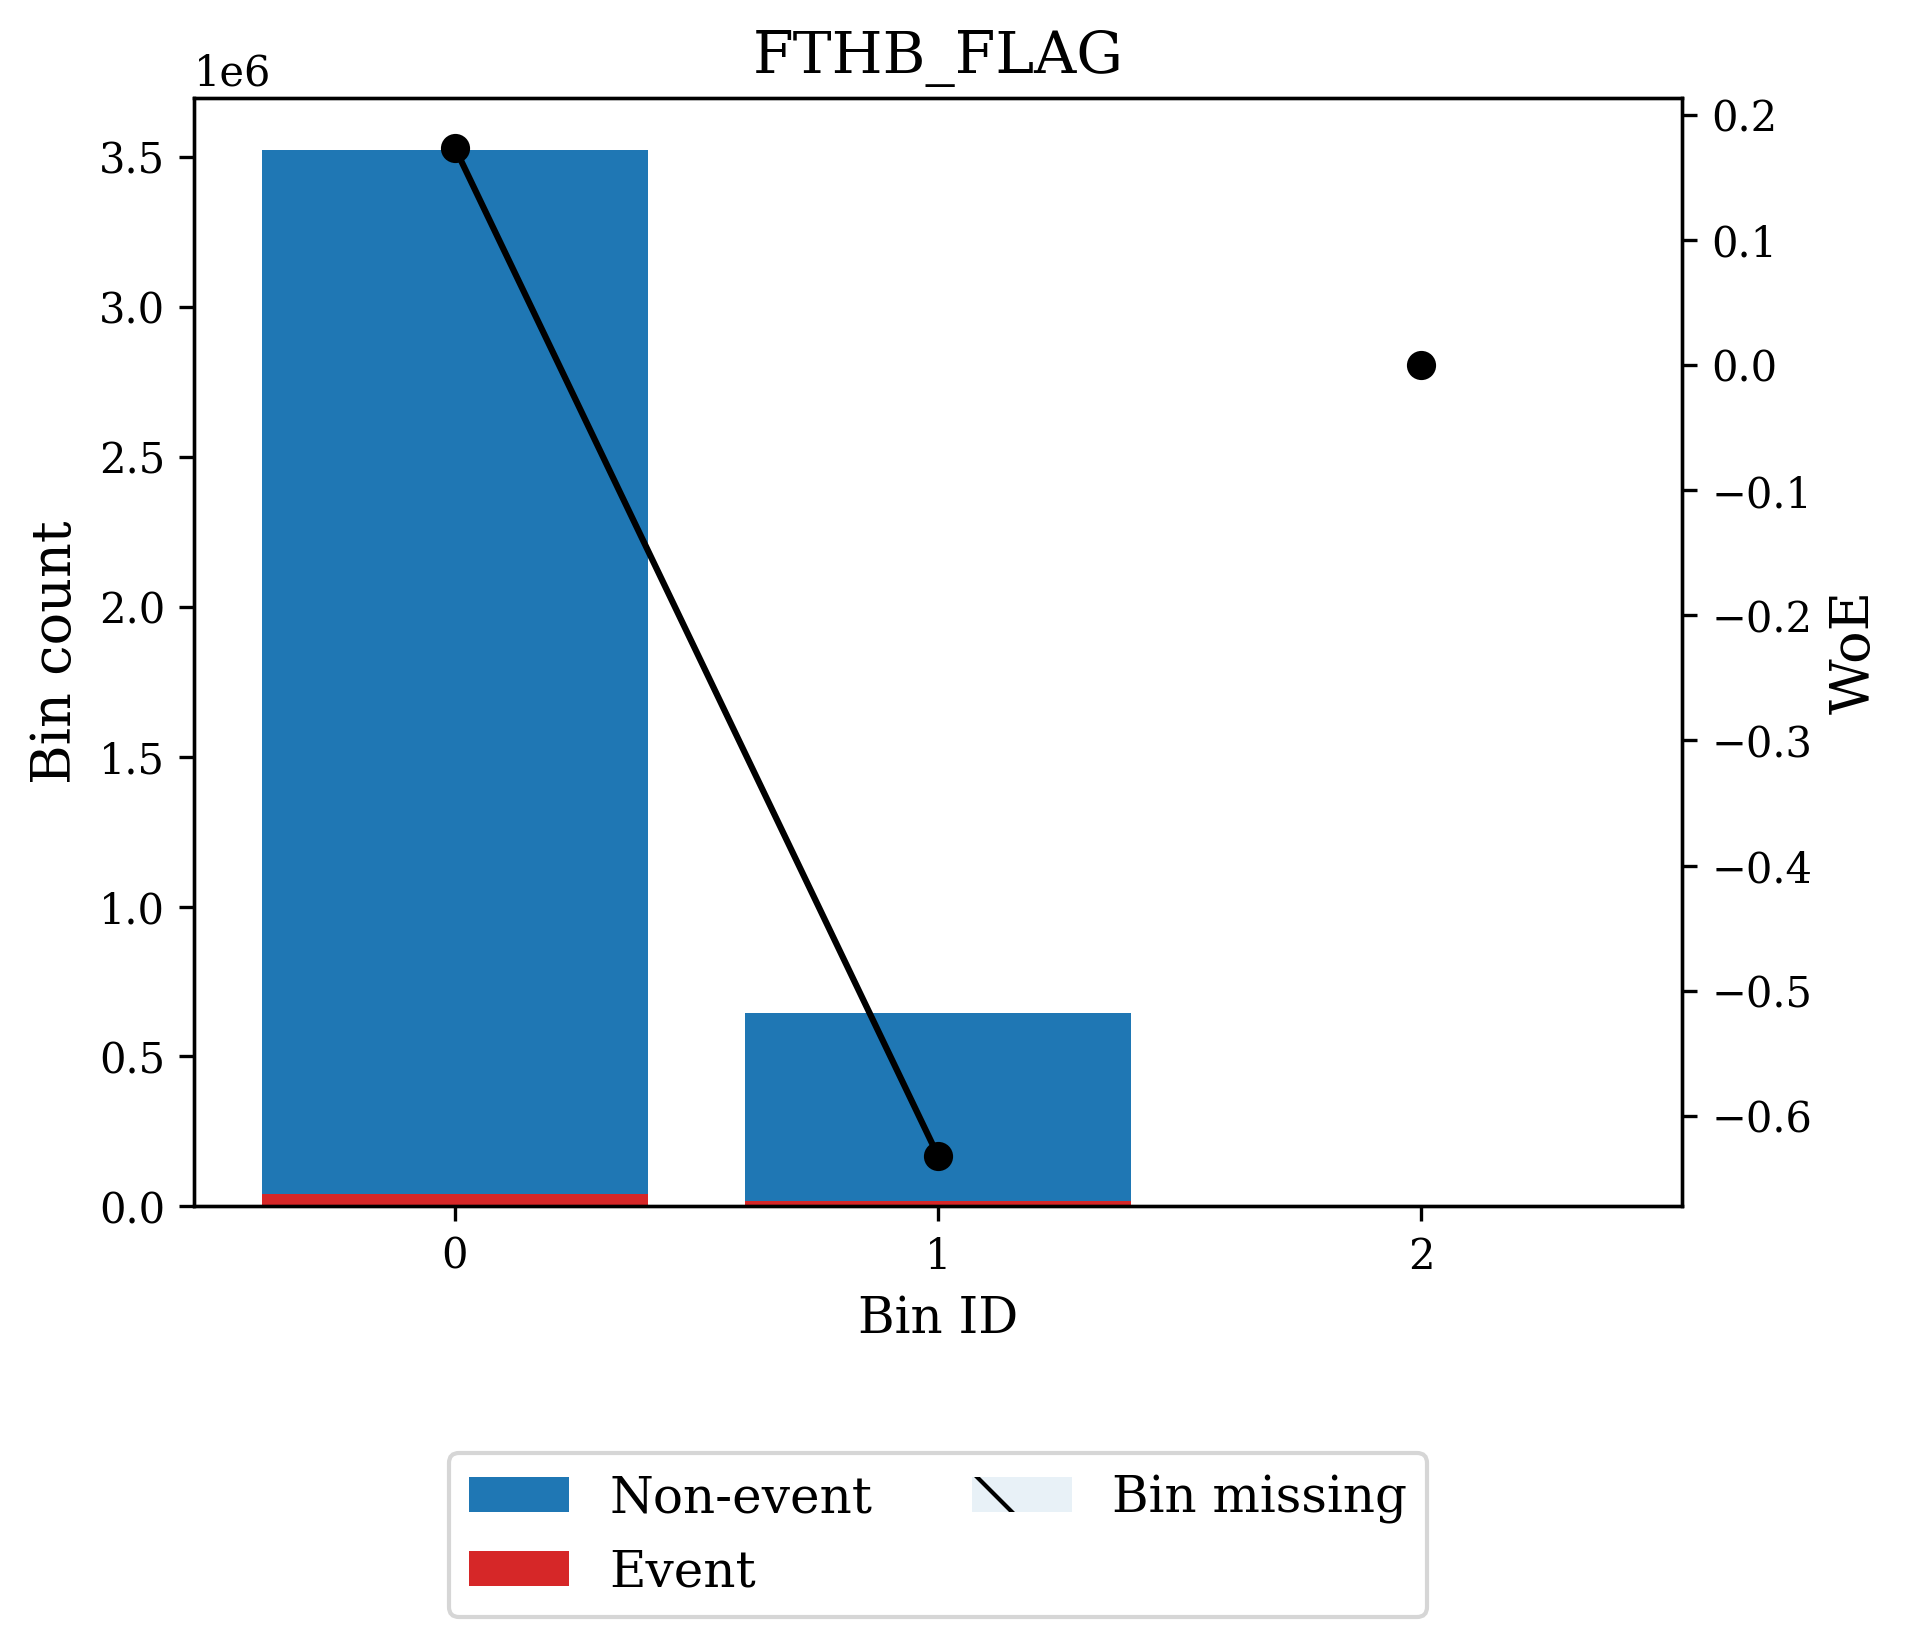

In [9]:
iv_per_col = {}
opt_bin_data = processed_df.copy()

for col in CAT_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="categorical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    iv_per_col[col] = optb.binning_table.iv
    optb.binning_table.plot(metric="woe",add_special=False,add_missing=True)
    opt_bin_data[col] = optb.transform(opt_bin_data[col], metric="woe")
    print()


## Numerical variables

In [10]:
NUMERICAL_COLUMNS = [
    "ORIG_RATE",
    "ORIG_AMOUNT",	
    "ORIG_TERM",
    "OLTV",
    "NUM_BO", 
    "DTI",
    "CSCORE_B", 
    "CSCORE_C",
    "NUM_UNIT",
    "MI_PCT"]

In [11]:
help(OptimalBinning)

Help on class OptimalBinning in module optbinning.binning.binning:

class OptimalBinning(optbinning.binning.base.BaseOptimalBinning)
 |  OptimalBinning(name='', dtype='numerical', prebinning_method='cart', solver='cp', divergence='iv', max_n_prebins=20, min_prebin_size=0.05, min_n_bins=None, max_n_bins=None, min_bin_size=None, max_bin_size=None, min_bin_n_nonevent=None, max_bin_n_nonevent=None, min_bin_n_event=None, max_bin_n_event=None, monotonic_trend='auto', min_event_rate_diff=0, max_pvalue=None, max_pvalue_policy='consecutive', gamma=0, outlier_detector=None, outlier_params=None, class_weight=None, cat_cutoff=None, cat_unknown=None, user_splits=None, user_splits_fixed=None, special_codes=None, split_digits=None, mip_solver='bop', time_limit=100, verbose=False, **prebinning_kwargs)
 |
 |  Optimal binning of a numerical or categorical variable with respect to a
 |  binary target.
 |
 |  Parameters
 |  ----------
 |  name : str, optional (default="")
 |      The variable name.
 |
 | 

COLUMN: ORIG_RATE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.45)",524327,0.125813,522209,2118,0.004039,1.217139,0.108828,0.012821
1,"[2.45, 2.59)",271135,0.065059,269589,1546,0.005702,0.870771,0.033196,0.004023
2,"[2.59, 2.64)",303586,0.072846,301457,2129,0.007013,0.662518,0.023534,0.002889
3,"[2.64, 2.81)",540282,0.129641,535680,4602,0.008518,0.466589,0.022668,0.002808
4,"[2.81, 2.92)",614506,0.147451,607944,6562,0.010678,0.238331,0.007474,0.000932
5,"[2.92, 3.10)",565662,0.135731,557905,7757,0.013713,-0.014864,0.000030,0.000004
6,"[3.10, 3.15)",312993,0.075103,308318,4675,0.014936,-0.101554,0.000814,0.000102
7,"[3.15, 3.25)",400070,0.095997,392543,7527,0.018814,-0.336307,0.012837,0.001597
8,"[3.25, 3.56)",411265,0.098683,400469,10796,0.026251,-0.676996,0.063833,0.007830
9,"[3.56, inf)",223695,0.053676,215089,8606,0.038472,-1.071865,0.107715,0.012855


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.33902226
    IV (Jeffrey)             0.38092959
    JS (Jensen-Shannon)      0.04586137
    Hellinger                0.04671412
    Triangular               0.17715518
    KS                       0.24299975
    HHI                      0.10981499
    HHI (normalized)         0.02888908
    Cramer's V               0.07503797
    Quality score            0.96973128

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1   107.735010  3.072274e-25  1.069879e-43       1.0
        1      2    38.736822  4.849733e-10  5.955201e-12       1.0
        2      3    55.633406  8.732696e-14  5.848097e-16       1.0
        3      4   140.198594  2.408719e-32  6.016982e-45       1.0
        4      5   226.300909  3.82015

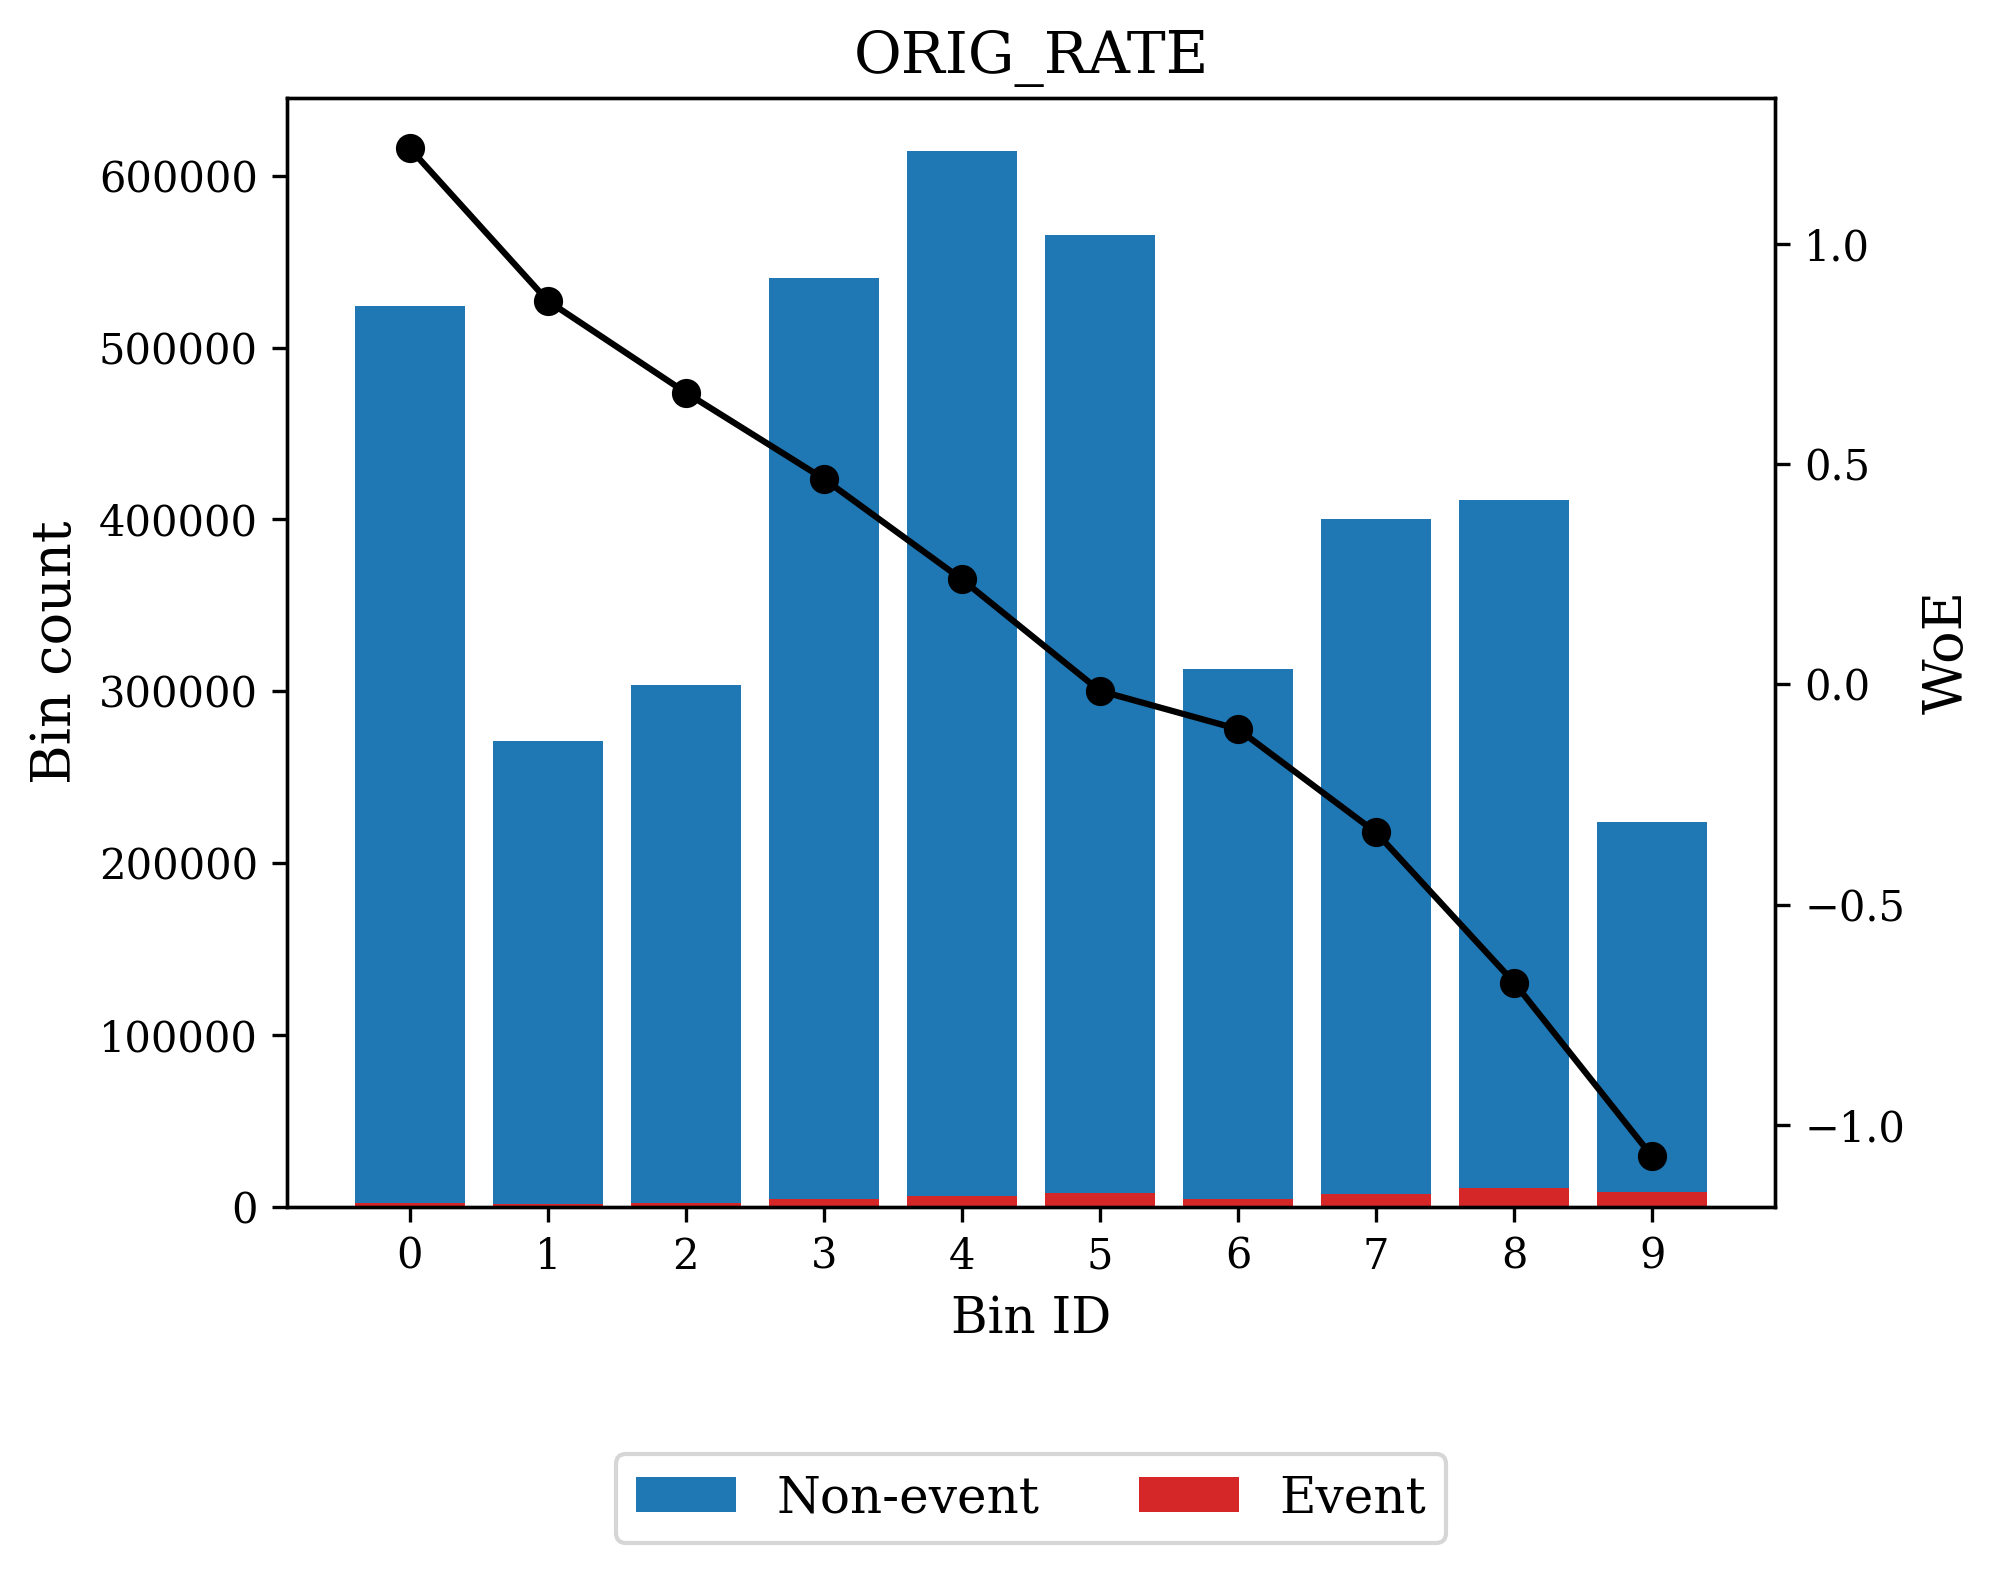


COLUMN: ORIG_AMOUNT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 211500.00)",1554392,0.372978,1534829,19563,0.012586,0.072077,0.001871,0.000234
1,"[211500.00, 251500.00)",489389,0.117429,483172,6217,0.012704,0.062628,0.000447,0.000056
2,"[251500.00, 350500.00)",961513,0.230716,949095,12418,0.012915,0.045905,0.000475,0.000059
3,"[350500.00, 402500.00)",349133,0.083775,343949,5184,0.014848,-0.09554,0.000801,0.000100
4,"[402500.00, inf)",813094,0.195103,800158,12936,0.015910,-0.165662,0.005809,0.000725
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.009404,0.001175


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.04769950
    IV (Jeffrey)             0.00940415
    JS (Jensen-Shannon)      0.00117459
    Hellinger                0.00117505
    Triangular               0.00469463
    KS                       0.04345430
    HHI                      0.25121493
    HHI (normalized)         0.12641742
    Cramer's V               0.01145796
    Quality score            0.01177011

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     0.415881 5.189997e-01 2.604687e-01  0.739531
        1      2     1.143869 2.848363e-01 1.416208e-01  0.858379
        2      3    72.241412 1.904175e-17 1.159462e-34  1.000000
        3      4    17.928655 2.293421e-05 7.976438e-06  0.999992

None


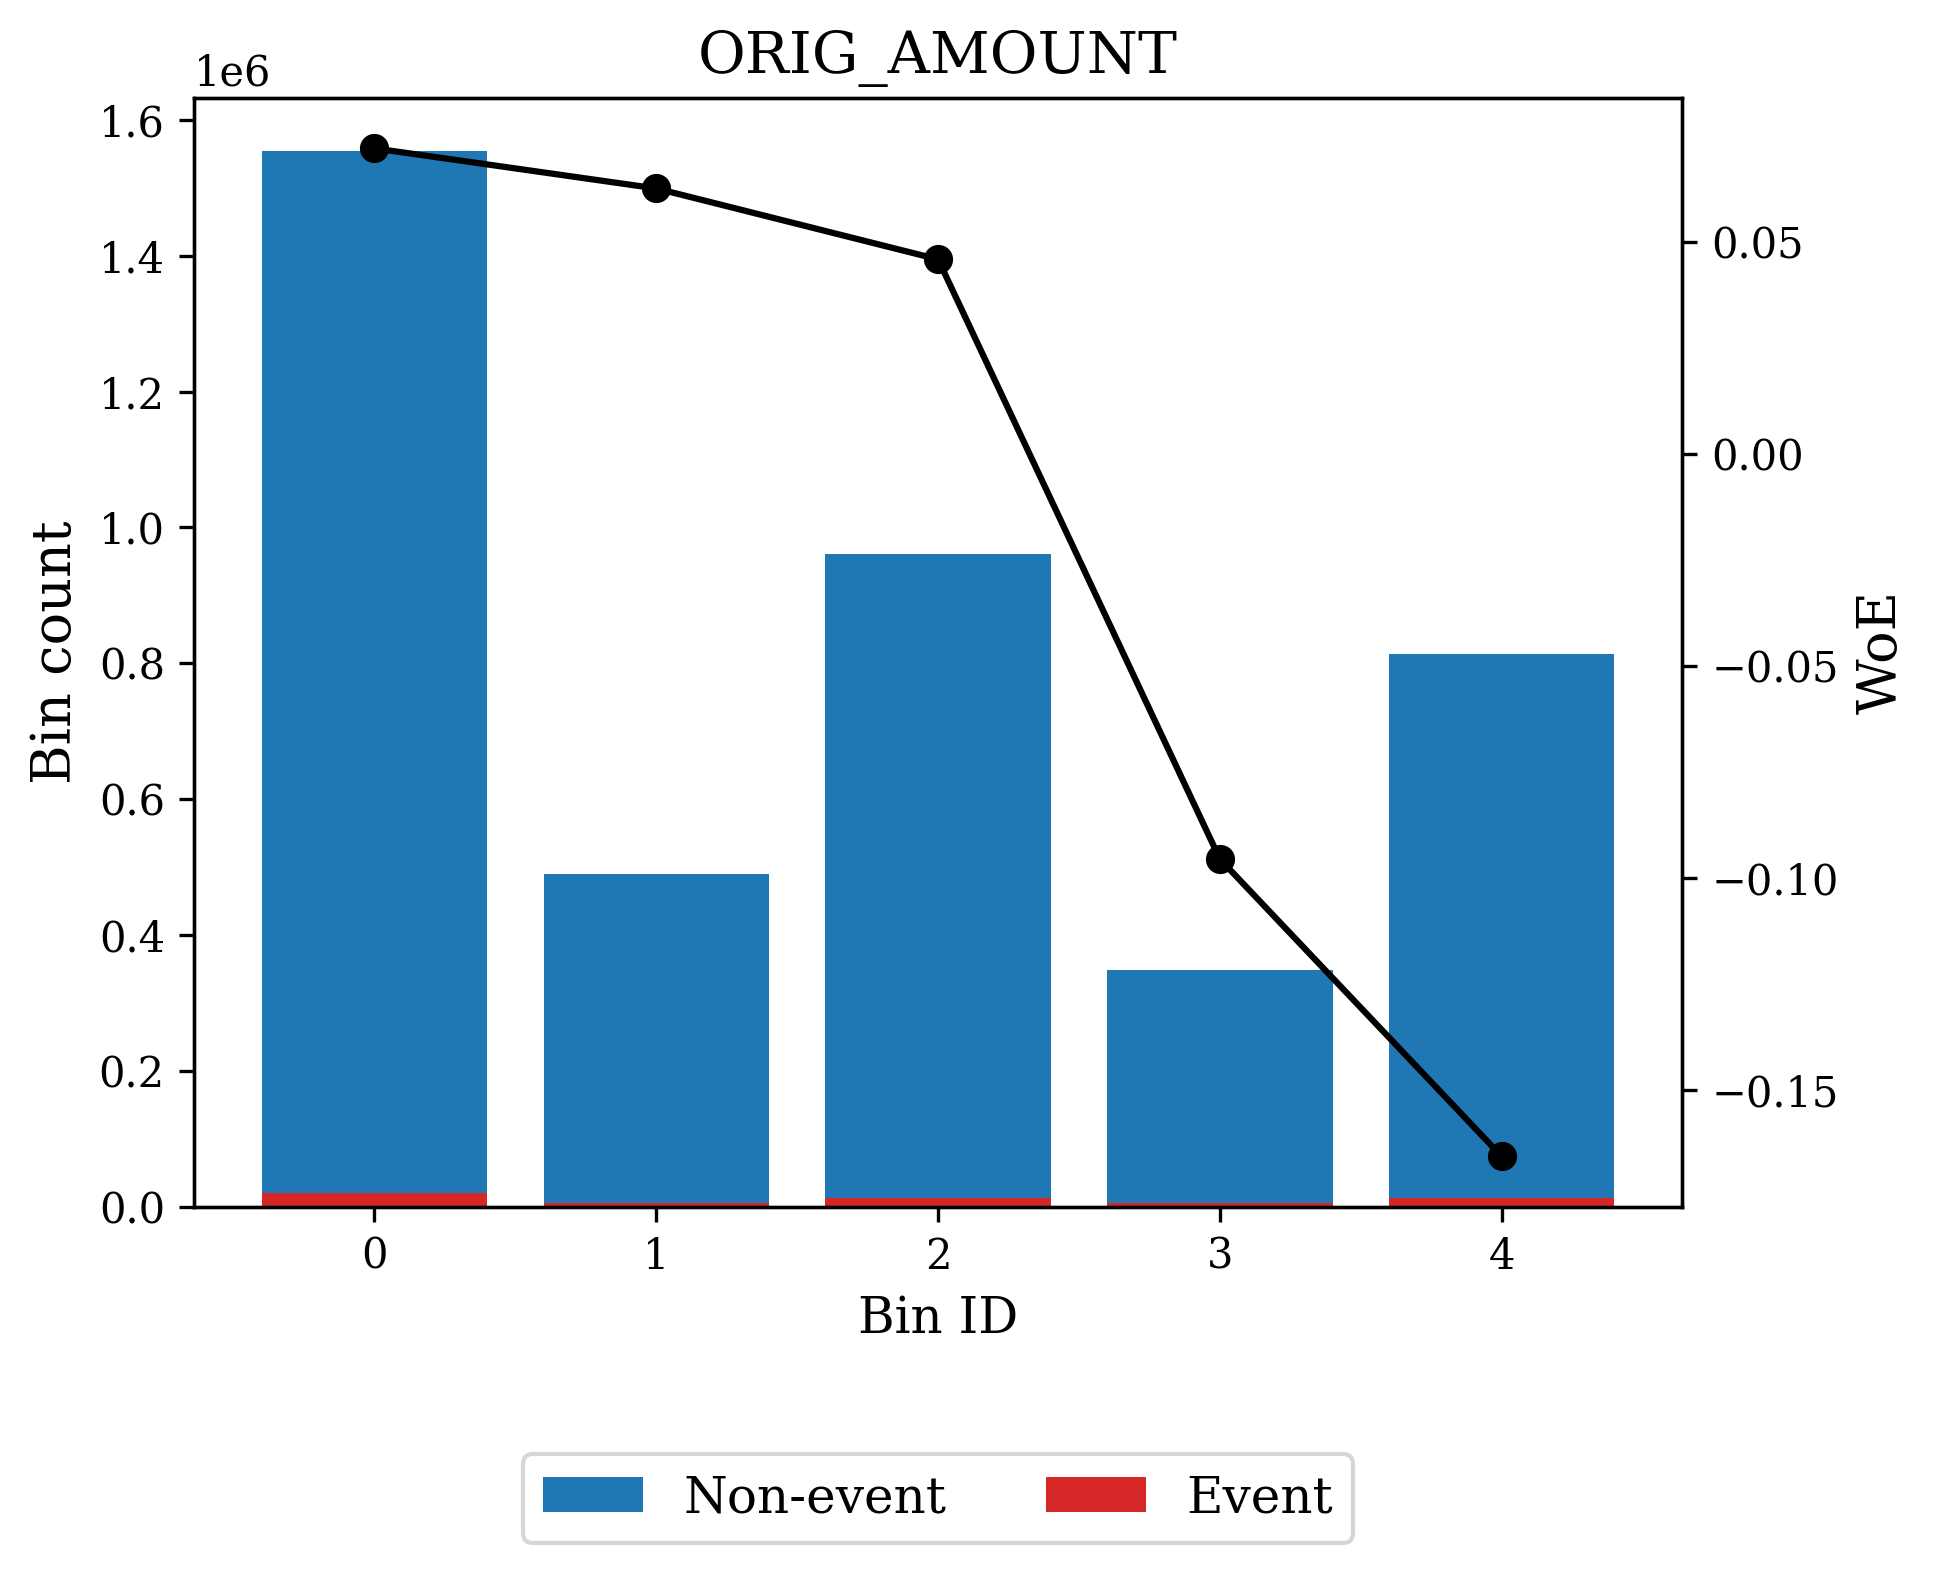


COLUMN: ORIG_TERM
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 228.50)",880398,0.211252,875837,4561,0.005181,0.967181,0.127716,0.015370
1,"[228.50, 318.50)",317517,0.076188,315526,1991,0.006271,0.775147,0.032087,0.003913
2,"[318.50, inf)",2969606,0.712559,2919840,49766,0.016758,-0.218505,0.037899,0.004728
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.197702,0.024011


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.17476107
    IV (Jeffrey)             0.19770225
    JS (Jensen-Shannon)      0.02401136
    Hellinger                0.02435460
    Triangular               0.09346571
    KS                       0.17344516
    HHI                      0.55817298
    HHI (normalized)         0.44771623
    Cramer's V               0.04430579
    Quality score            0.40152940

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    50.961524 9.419439e-13 1.922180e-22       1.0
        1      2  2035.954803 0.000000e+00 0.000000e+00       1.0

None


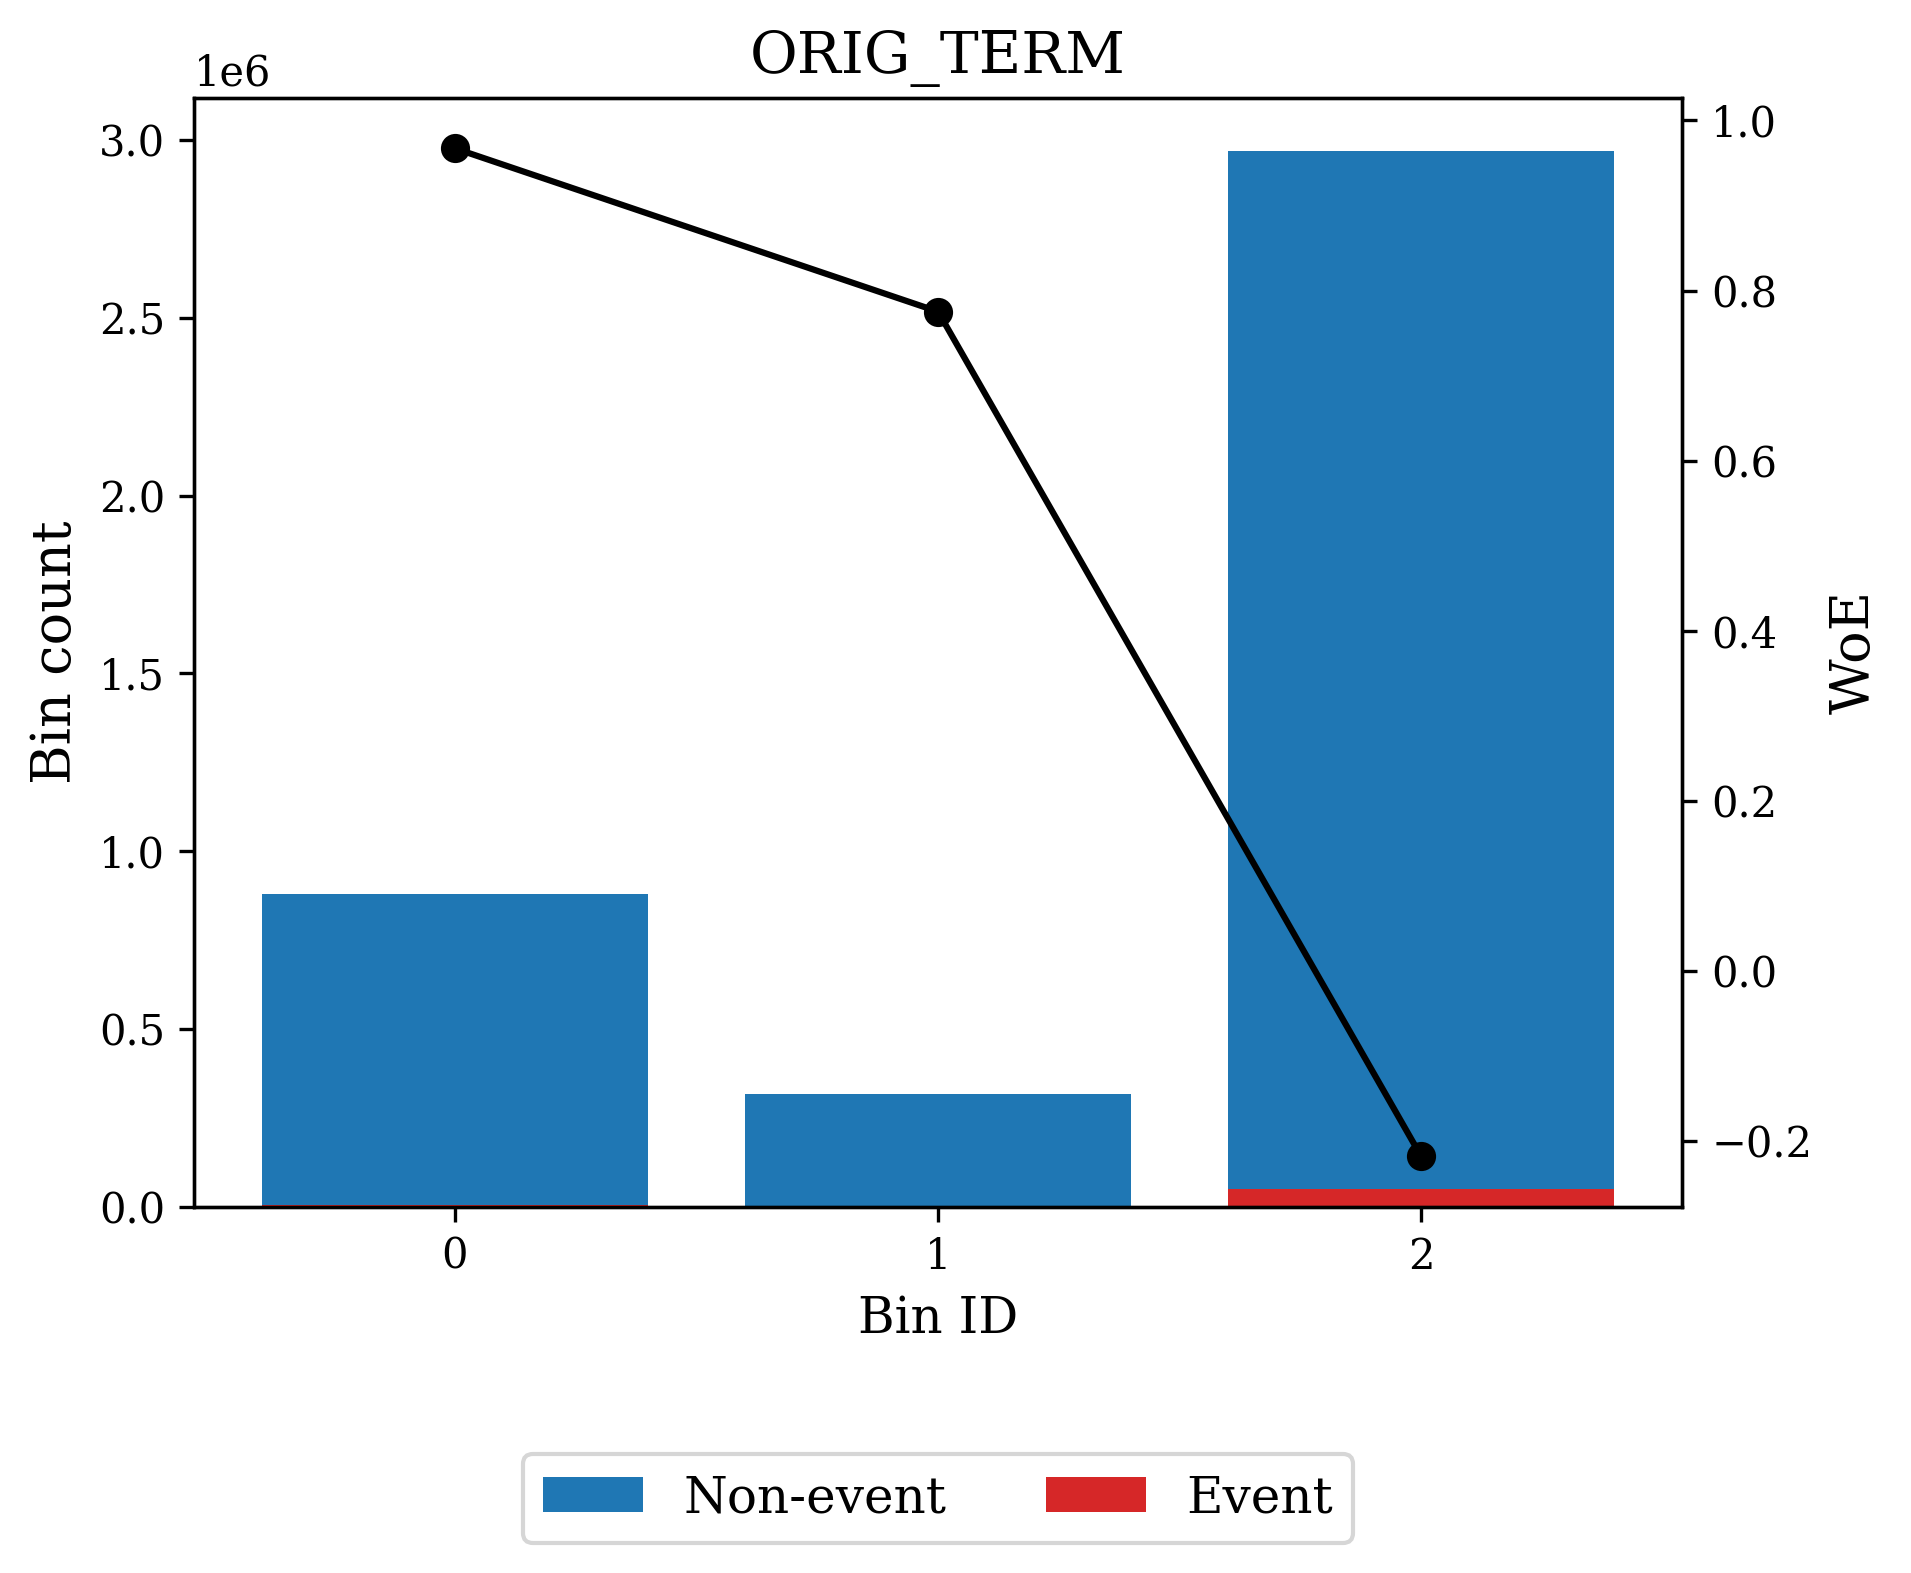


COLUMN: OLTV
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 35.50)",258918,0.062128,257935,983,0.003797,1.279397,0.057938,0.006785
1,"[35.50, 44.50)",277060,0.066481,275728,1332,0.004808,1.042277,0.045252,0.005414
2,"[44.50, 54.50)",470949,0.113005,468092,2857,0.006066,0.808436,0.051035,0.006211
3,"[54.50, 59.50)",332186,0.079708,329655,2531,0.007619,0.578975,0.020405,0.002516
4,"[59.50, 64.50)",343103,0.082328,339838,3265,0.009516,0.354753,0.008758,0.001089
5,"[64.50, 69.50)",330431,0.079287,326810,3621,0.010958,0.212172,0.003224,0.000402
6,"[69.50, 76.50)",642569,0.154185,633808,8761,0.013634,-0.009021,0.000013,0.000002
7,"[76.50, 84.50)",756263,0.181466,744629,11634,0.015384,-0.131503,0.003347,0.000418
8,"[84.50, 93.50)",307202,0.073713,300725,6477,0.021084,-0.452518,0.018942,0.002348
9,"[93.50, inf)",448840,0.107700,433983,14857,0.033101,-0.915923,0.144940,0.017510


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.32400730
    IV (Jeffrey)             0.35385325
    JS (Jensen-Shannon)      0.04269412
    Hellinger                0.04344305
    Triangular               0.16521518
    KS                       0.22695640
    HHI                      0.11420303
    HHI (normalized)         0.03367603
    Cramer's V               0.07139768
    Quality score            0.95514885

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1    31.813668  1.696944e-08  5.912011e-10       1.0
        1      2    49.639254  1.847794e-12  2.072119e-14       1.0
        2      3    70.478179  4.653859e-17  9.412835e-25       1.0
        3      4    71.366611  2.966499e-17  1.511519e-22       1.0
        4      5    34.603954  4.04084

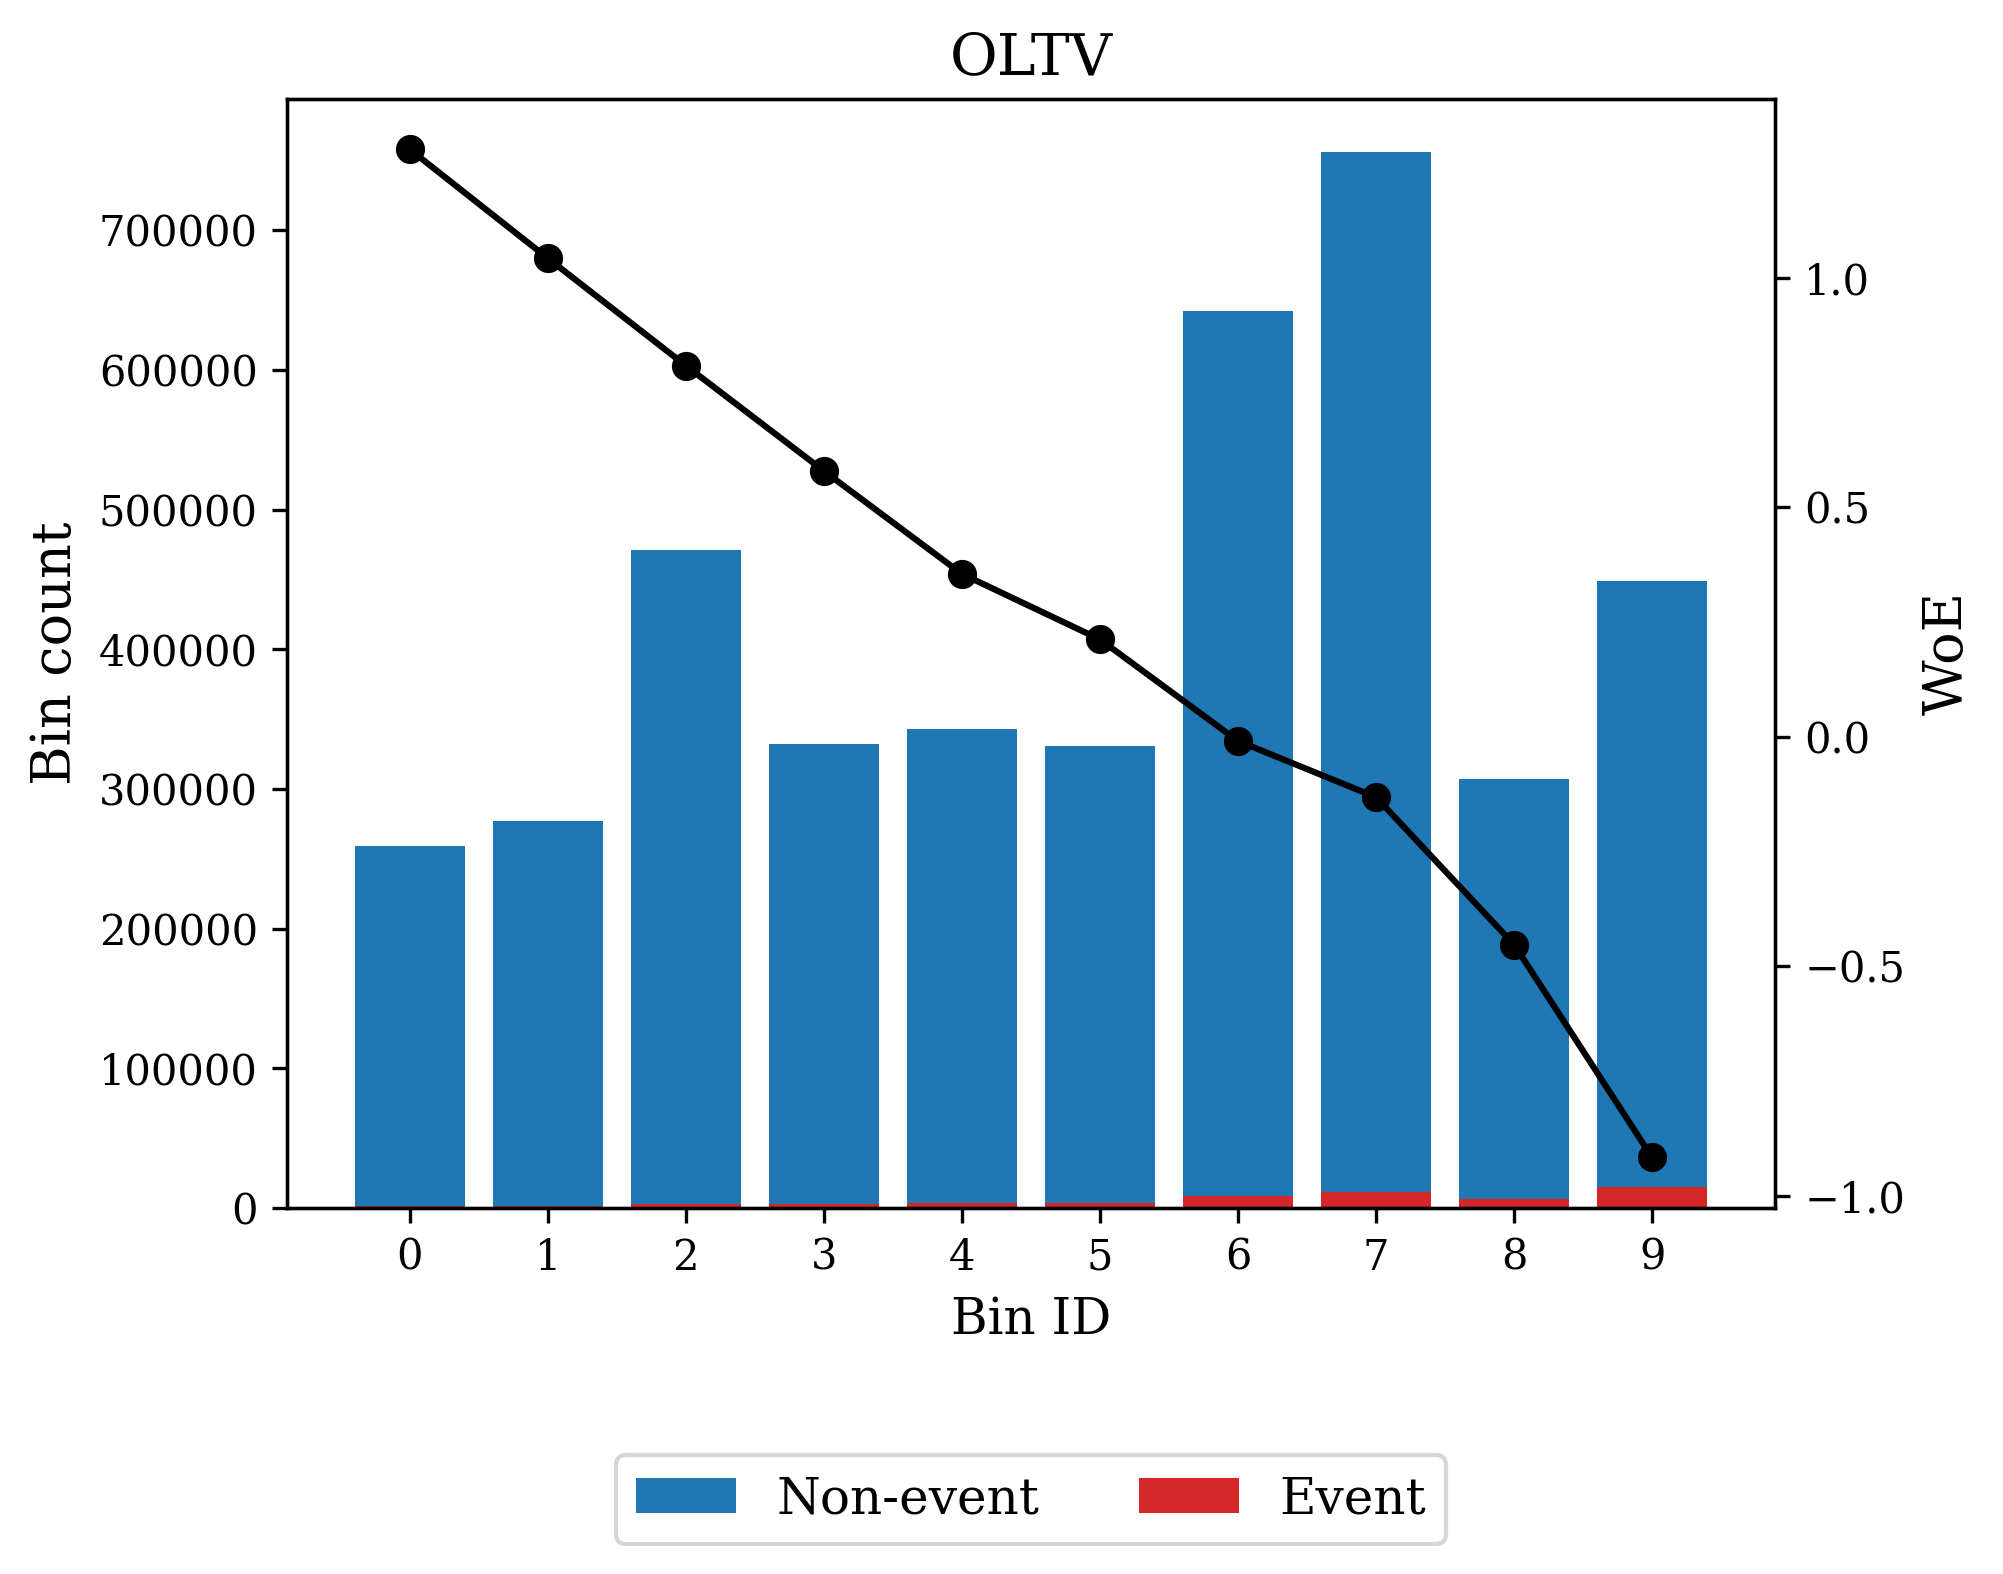


COLUMN: NUM_BO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",2231790,0.53552,2191598,40192,0.018009,-0.291738,0.052683,0.006562
1,"[1.50, inf)",1935731,0.46448,1919605,16126,0.008331,0.488985,0.088302,0.010929
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.00000,4111203,56318,0.013514,,0.140985,0.017491


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.18058222
    IV (Jeffrey)             0.14098479
    JS (Jensen-Shannon)      0.01749118
    Hellinger                0.01755679
    Triangular               0.06944795
    KS                       0.18058222
    HHI                      0.50252331
    HHI (normalized)         0.33669775
    Cramer's V               0.04180554
    Quality score            0.36564714

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  7283.591284      0.0       1.0       0.0

None


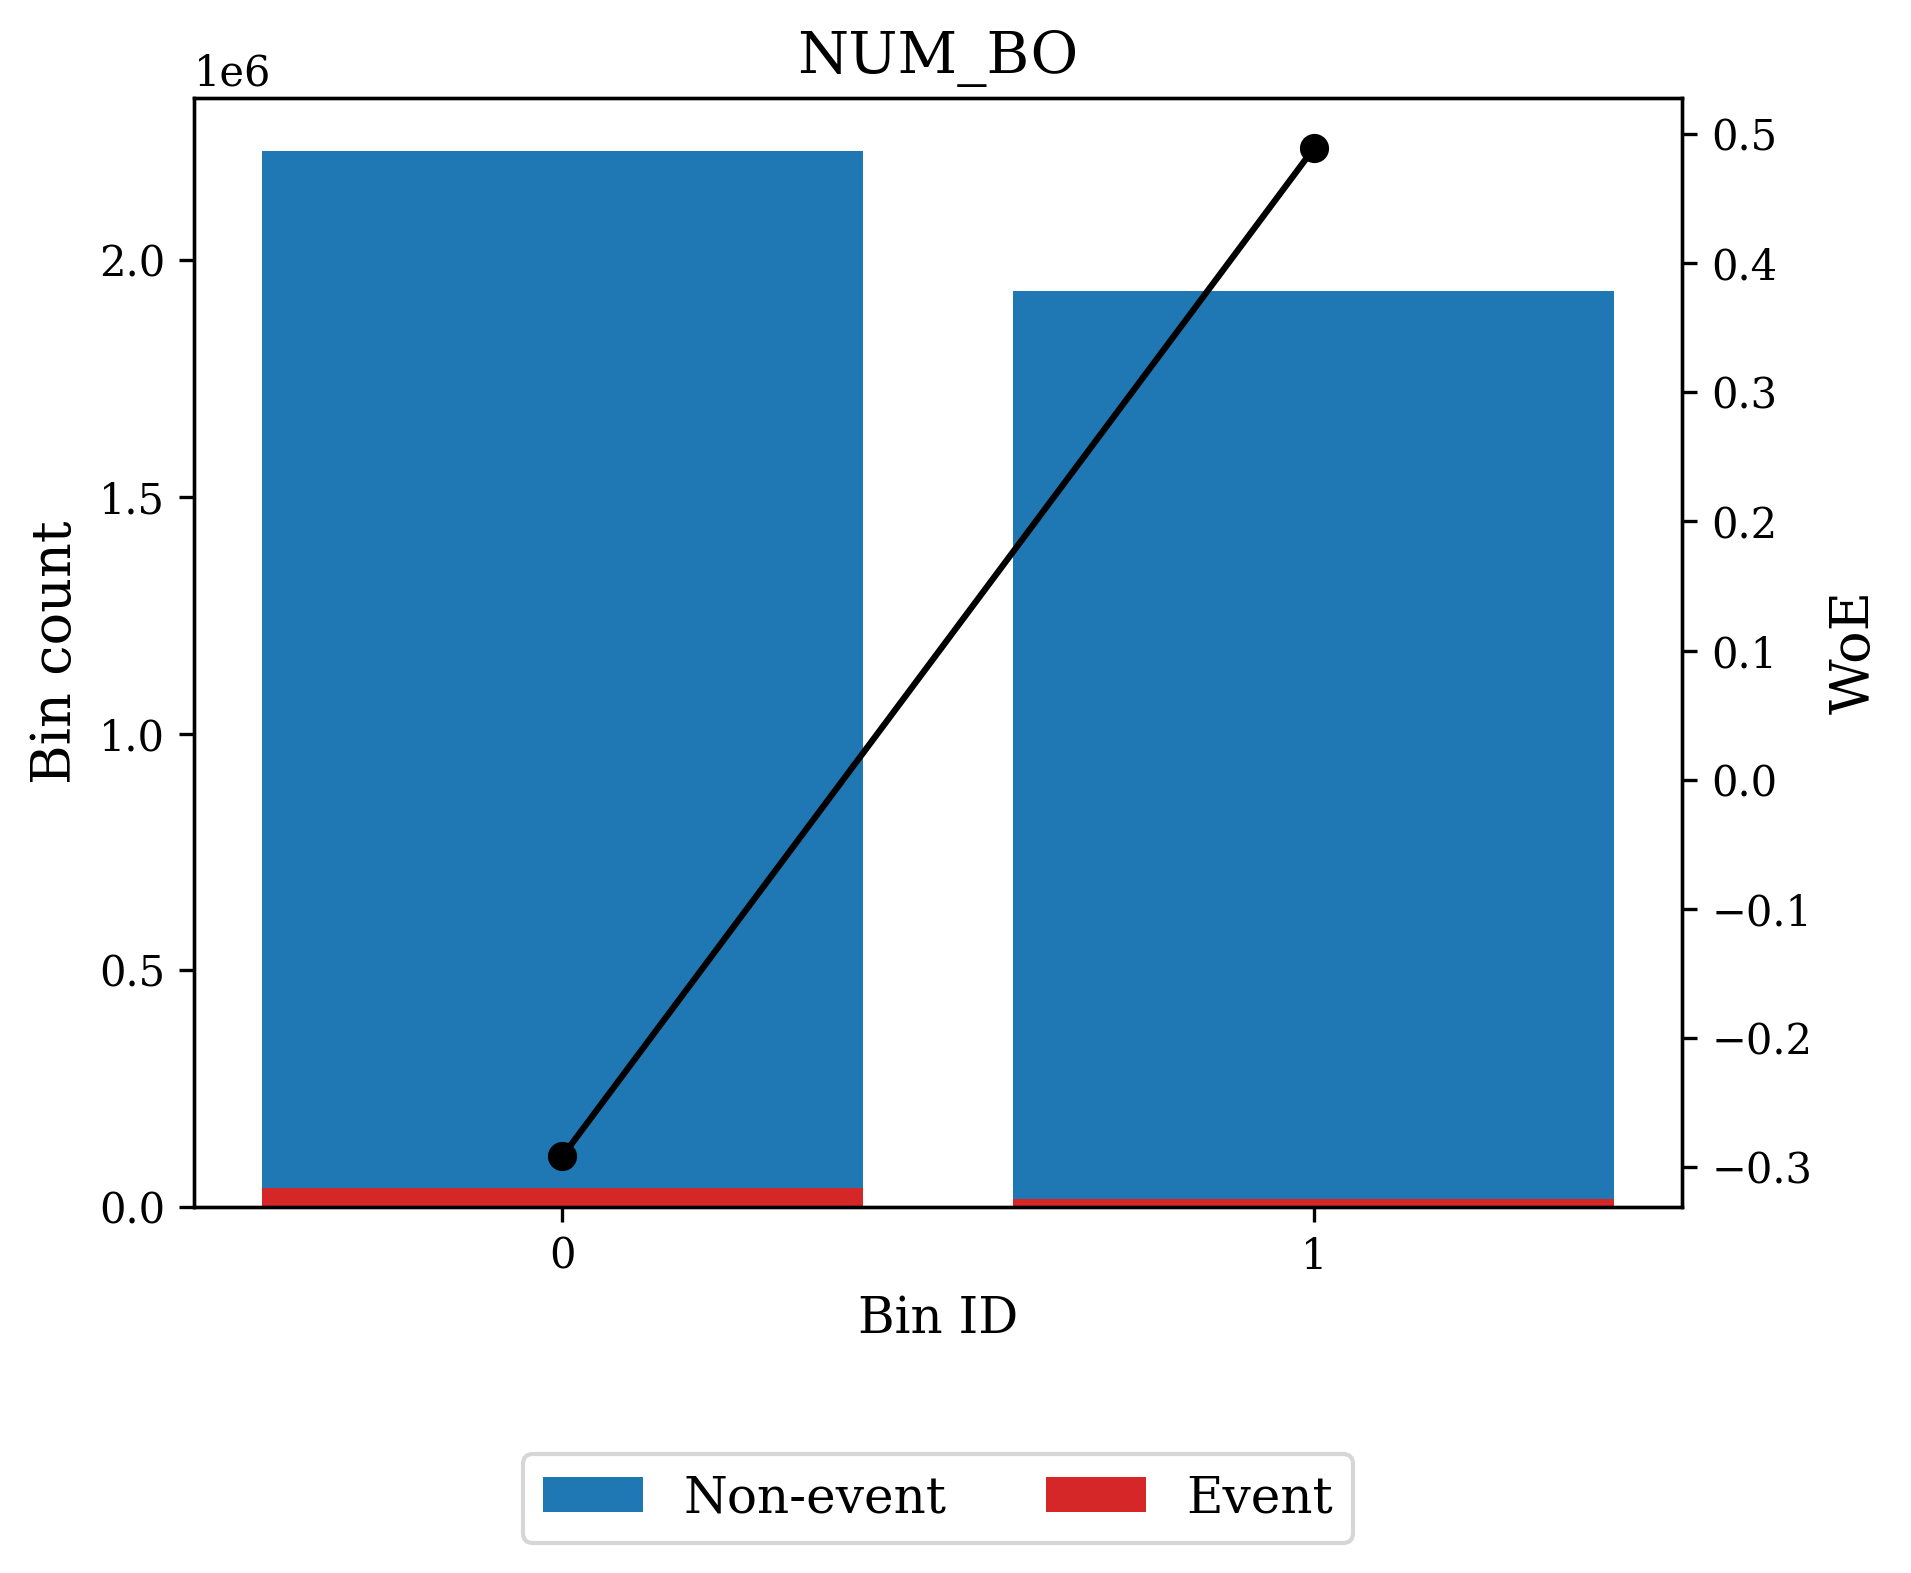


COLUMN: DTI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 16.50)",214246,0.051408,213565,681,0.003179,1.457677,0.058096,0.006680
1,"[16.50, 22.50)",446720,0.107191,444602,2118,0.004741,1.05625,0.074504,0.008903
2,"[22.50, 25.50)",311273,0.074690,309243,2030,0.006522,0.735635,0.028818,0.003523
3,"[25.50, 27.50)",230765,0.055372,228931,1834,0.007947,0.536465,0.012403,0.001532
4,"[27.50, 31.50)",500885,0.120188,495919,4966,0.009914,0.313341,0.010167,0.001266
5,"[31.50, 34.50)",396557,0.095154,391567,4990,0.012583,0.072264,0.000480,0.000060
6,"[34.50, 37.50)",409109,0.098166,403192,5917,0.014463,-0.068873,0.000482,0.000060
7,"[37.50, 39.50)",279541,0.067076,274901,4640,0.016599,-0.20876,0.003241,0.000404
8,"[39.50, 42.50)",431437,0.103524,422844,8593,0.019917,-0.394401,0.019613,0.002436
9,"[42.50, inf)",946988,0.227231,926439,20549,0.021699,-0.481921,0.067242,0.008325


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.27355808
    IV (Jeffrey)             0.27504494
    JS (Jensen-Shannon)      0.03318942
    Hellinger                0.03376415
    Triangular               0.12859297
    KS                       0.21177335
    HHI                      0.12276346
    HHI (normalized)         0.04301469
    Cramer's V               0.05541972
    Quality score            0.86130118

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    83.850140 5.337381e-20 8.367823e-24       1.0
        1      2   106.843323 4.817923e-25 9.732382e-39       1.0
        2      3    38.066482 6.837467e-10 1.154937e-12       1.0
        3      4    66.382073 3.714651e-16 1.464147e-18       1.0
        4      5   143.699427 4.133396e-33 6.461

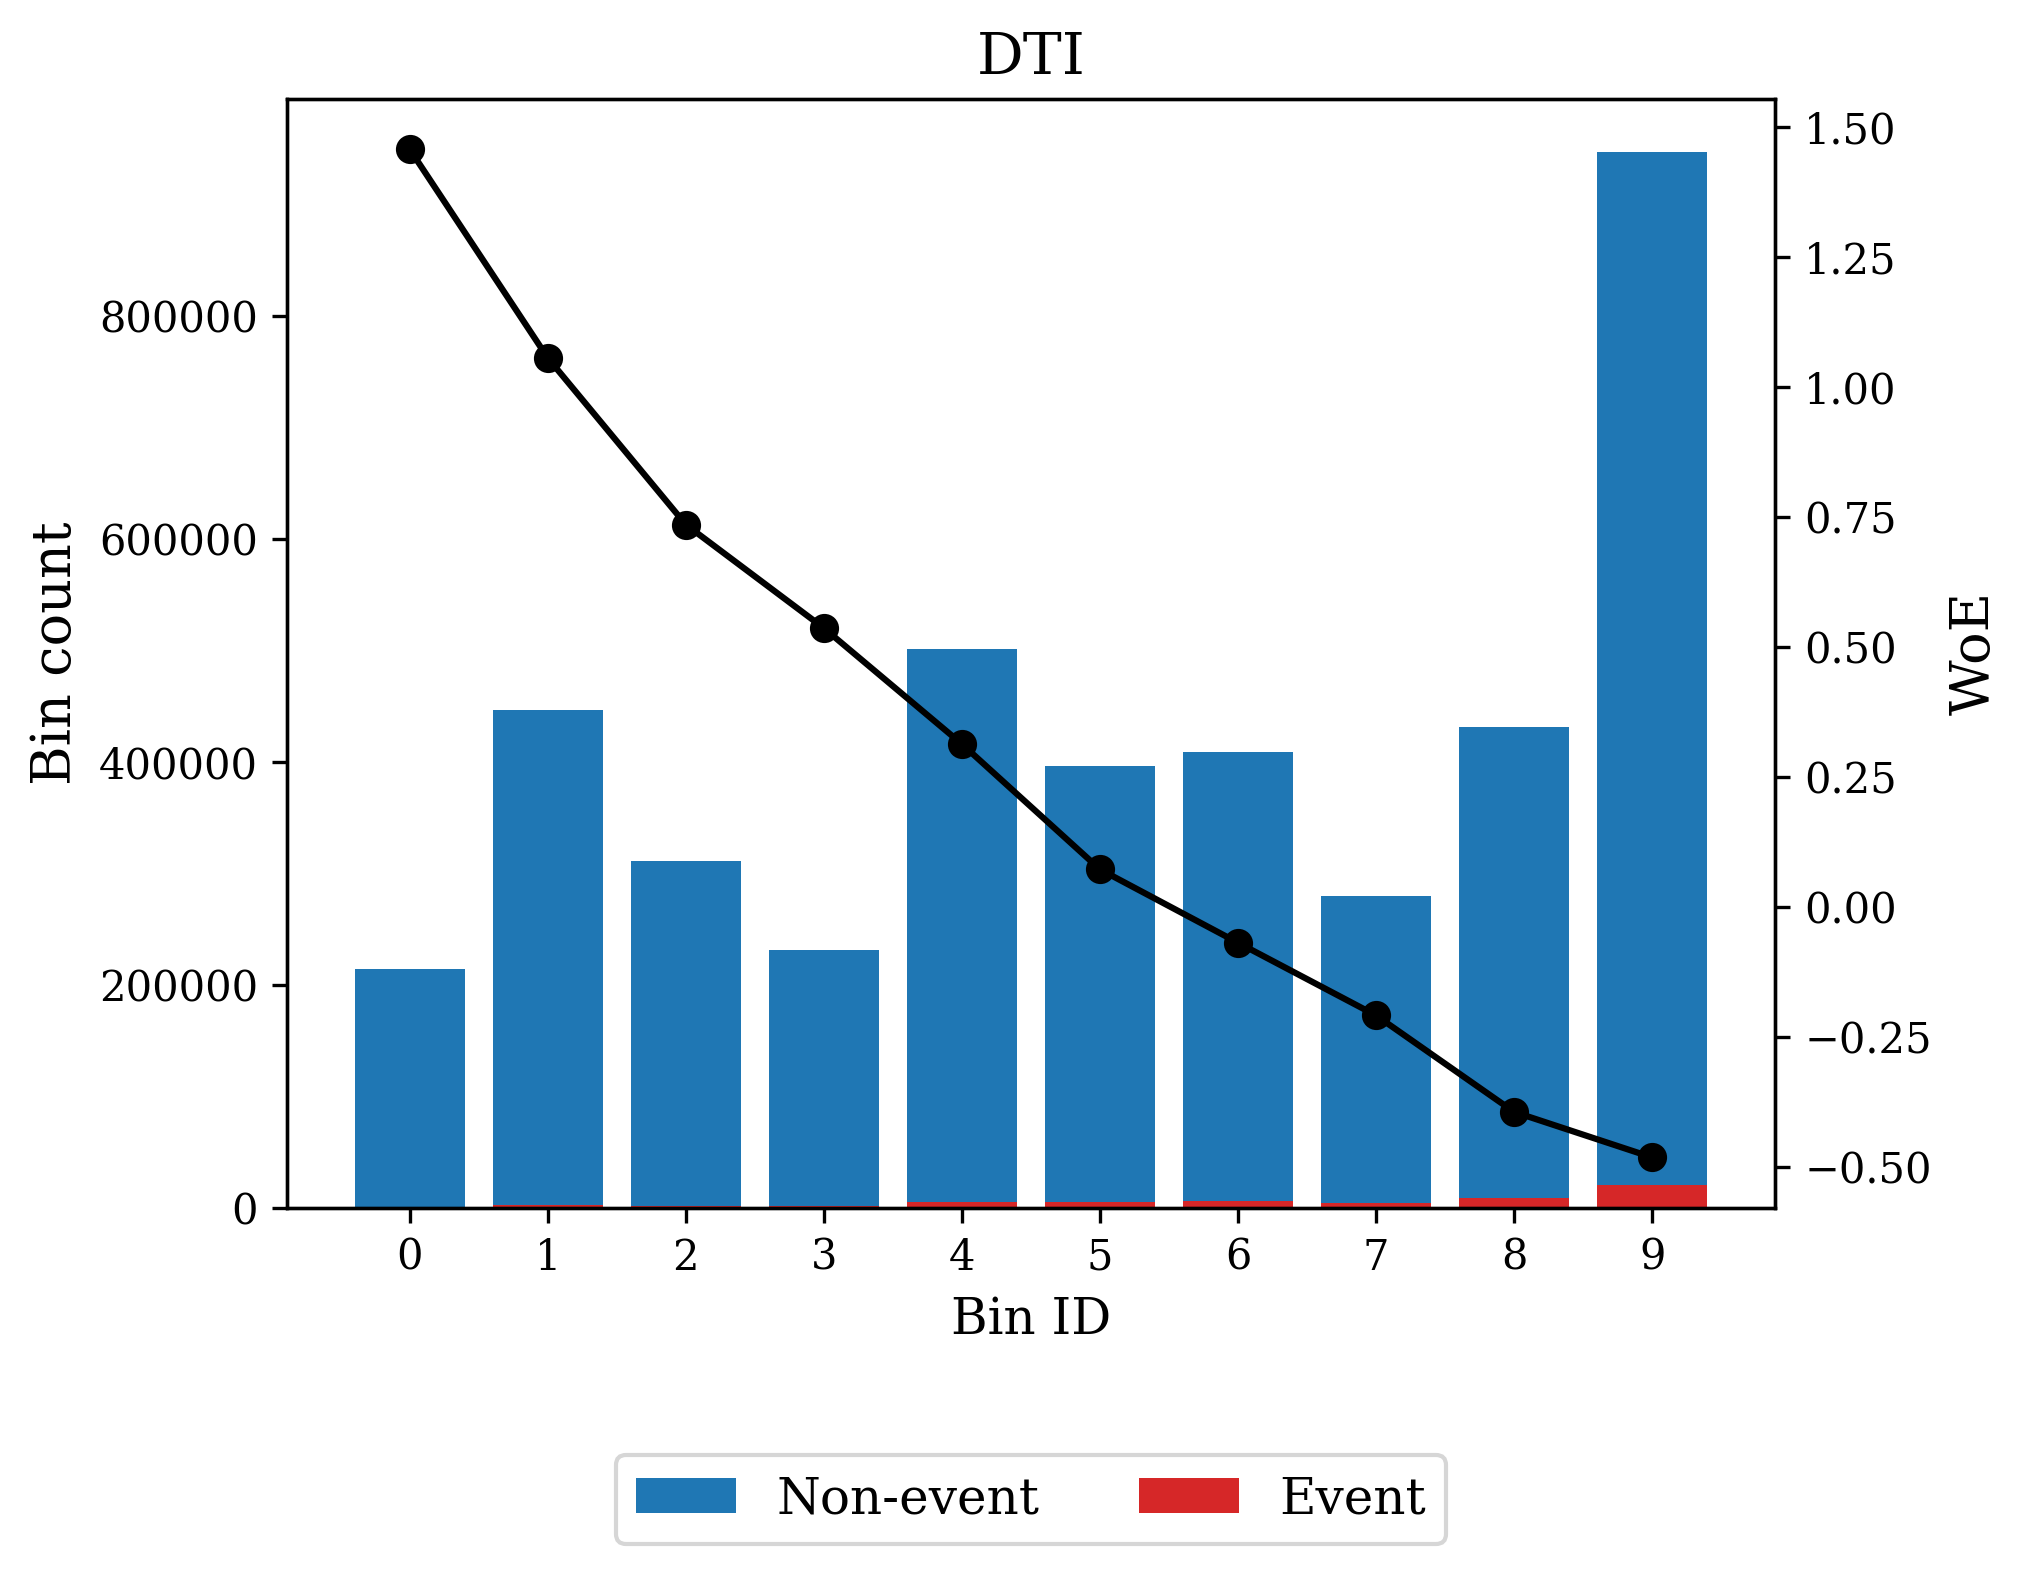


COLUMN: CSCORE_B
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 676.50)",209556,0.050283,196052,13504,0.064441,-1.615063,0.310244,0.035049
1,"[676.50, 697.50)",216602,0.051974,208171,8431,0.038924,-1.084012,0.107391,0.012803
2,"[697.50, 714.50)",253302,0.060780,245878,7424,0.029309,-0.790339,0.056917,0.006935
3,"[714.50, 736.50)",388986,0.093338,380642,8344,0.021451,-0.47014,0.026127,0.003236
4,"[736.50, 752.50)",375015,0.089985,369558,5457,0.014551,-0.075048,0.000526,0.000066
5,"[752.50, 766.50)",415769,0.099764,411727,4042,0.009722,0.333164,0.009454,0.001176
6,"[766.50, 784.50)",697928,0.167468,693697,4231,0.006062,0.80914,0.075741,0.009217
7,"[784.50, 792.50)",383009,0.091903,381450,1559,0.004070,1.209478,0.078738,0.009283
8,"[792.50, 803.50)",590410,0.141669,588505,1905,0.003227,1.442647,0.157711,0.018165
9,"[803.50, inf)",636944,0.152835,635523,1421,0.002231,1.812631,0.234466,0.025858


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.54482313
    IV (Jeffrey)             1.05731565
    JS (Jensen-Shannon)      0.12178754
    Hellinger                0.12667487
    Triangular               0.45388402
    KS                       0.42575630
    HHI                      0.11560666
    HHI (normalized)         0.03520727
    Cramer's V               0.13375329
    Quality score            0.11976366

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1420.484902 7.430863e-311       1.0 0.000000e+00
        1      2   331.087781  5.570169e-74       1.0 0.000000e+00
        2      3   395.586942  5.030544e-88       1.0 0.000000e+00
        3      4   512.376974 1.927771e-113       1.0 0.000000e+00
        4      5   387.531289  2.853139e-86

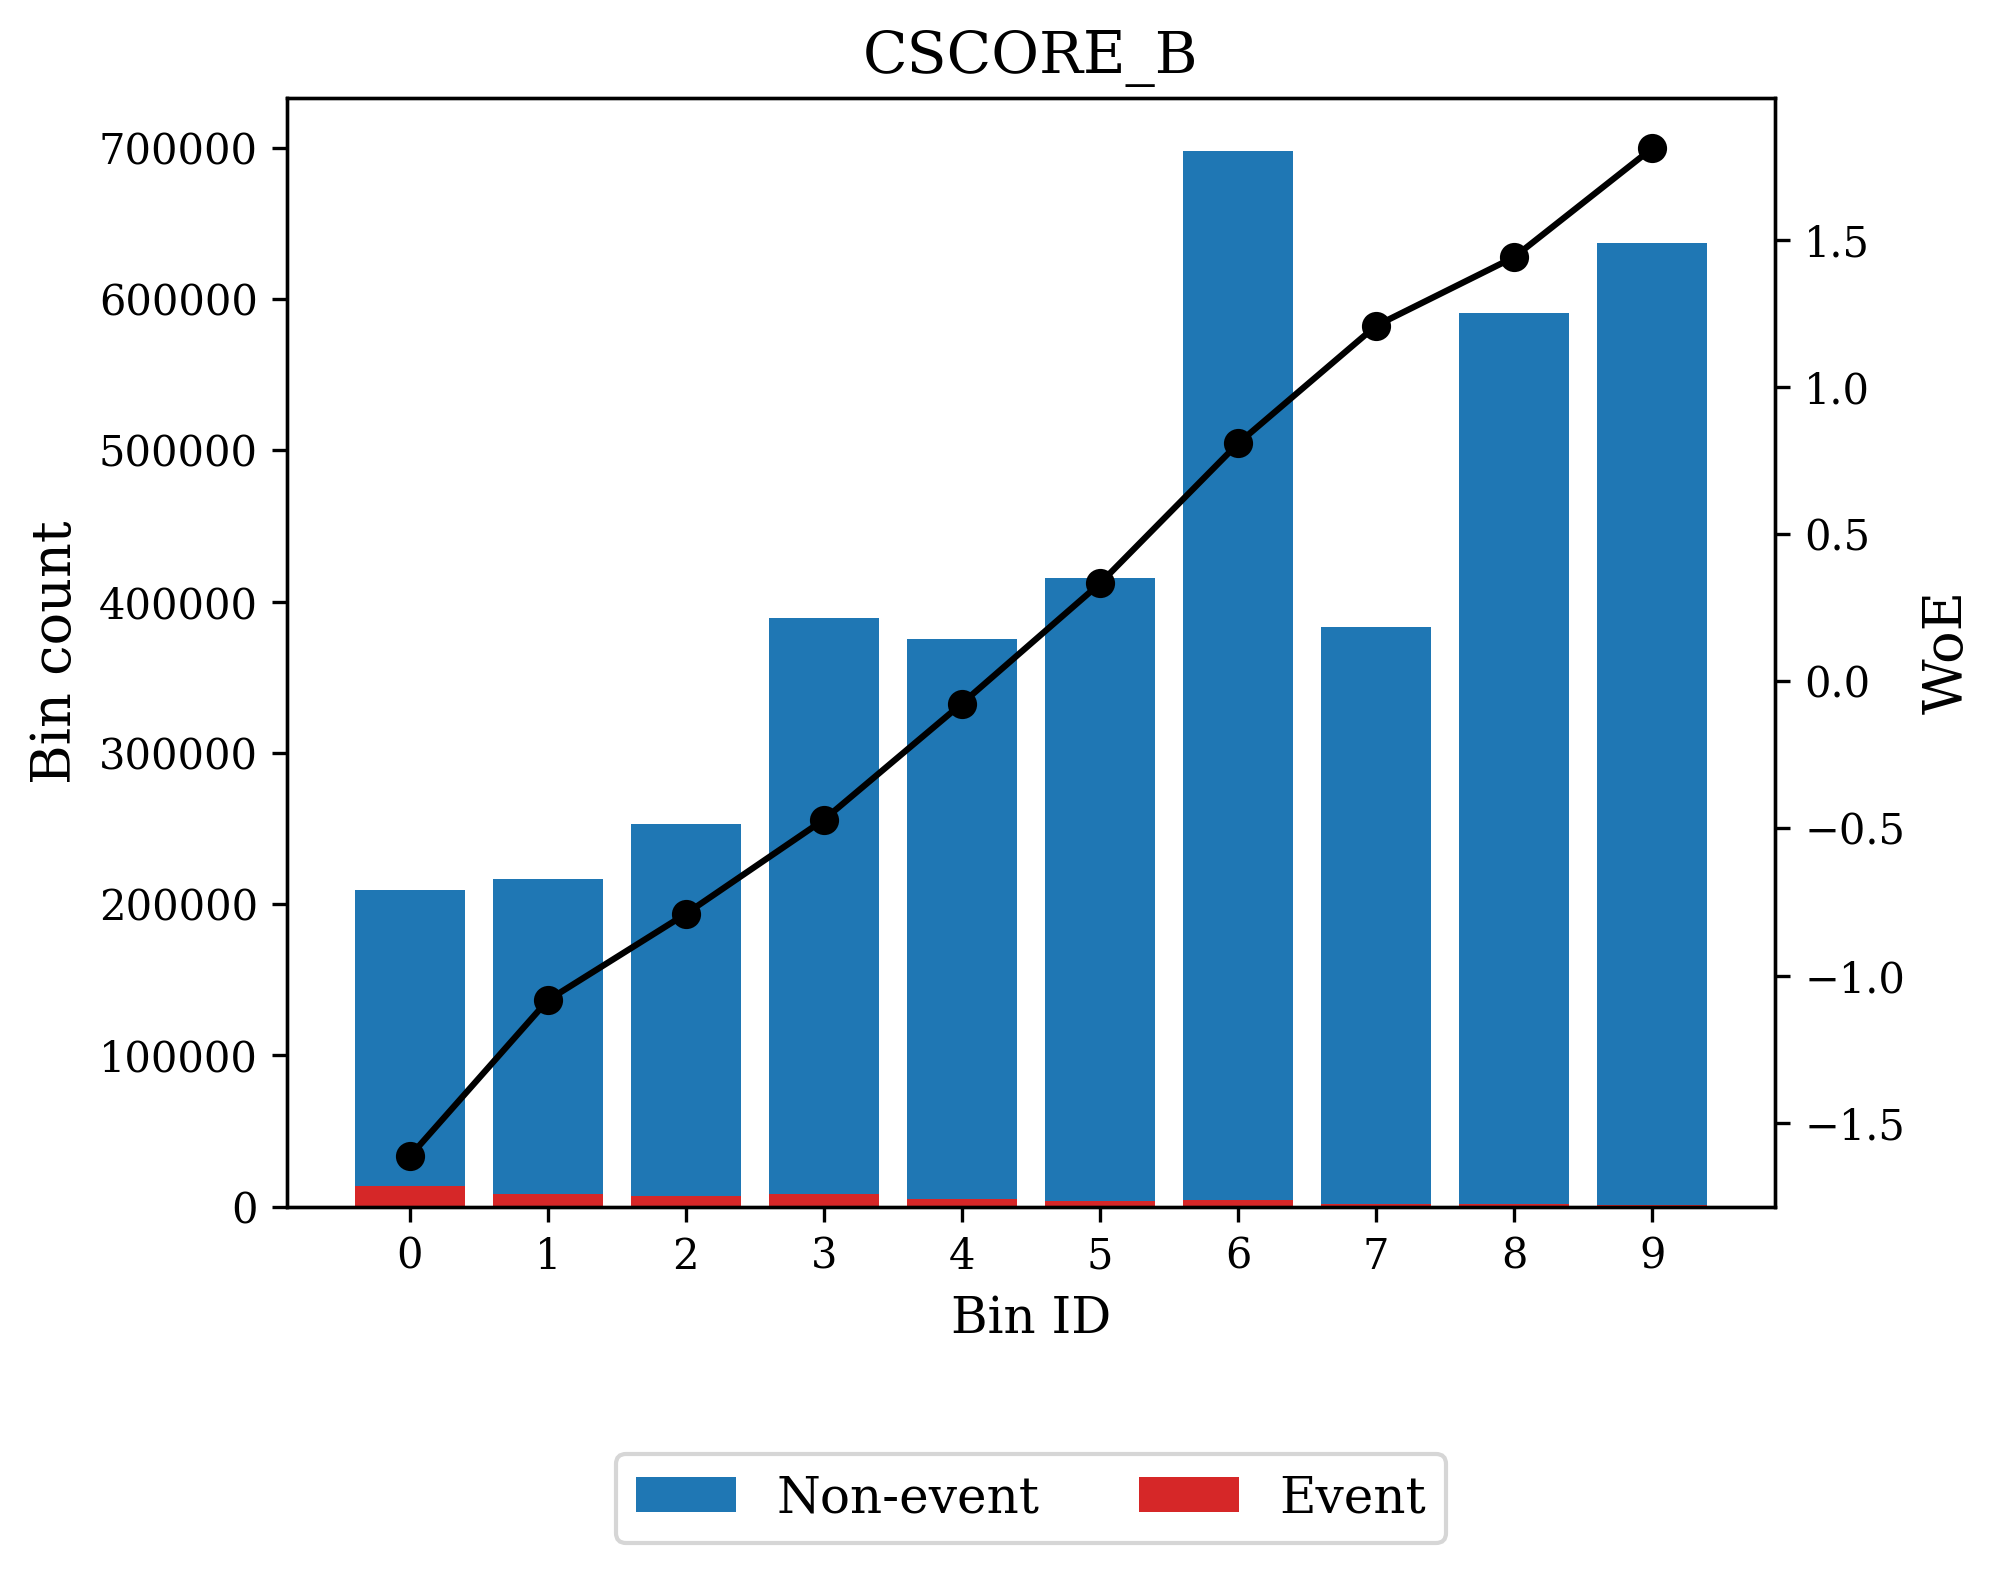


COLUMN: CSCORE_C
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 677.50)",212077,0.050888,199053,13024,0.061412,-1.563679,0.285905,0.032491
1,"[677.50, 701.50)",259246,0.062206,249626,9620,0.037108,-1.034337,0.113878,0.013632
2,"[701.50, 720.50)",293353,0.070390,285385,7968,0.027162,-0.712051,0.051315,0.006282
3,"[720.50, 736.50)",293928,0.070528,287772,6156,0.020944,-0.445715,0.017521,0.002172
4,"[736.50, 746.50)",225951,0.054217,222456,3495,0.015468,-0.137061,0.001089,0.000136
5,"[746.50, 759.50)",348347,0.083586,344184,4163,0.011951,0.124484,0.001220,0.000152
6,"[759.50, 770.50)",352983,0.084699,349909,3074,0.008709,0.444237,0.013562,0.001681
7,"[770.50, 782.50)",467560,0.112191,464624,2936,0.006279,0.773724,0.047106,0.005746
8,"[782.50, 798.50)",770335,0.184842,767054,3281,0.004259,1.163952,0.149356,0.017682
9,"[798.50, inf)",943741,0.226451,941140,2601,0.002756,1.600739,0.292514,0.033101


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.52671584
    IV (Jeffrey)             0.97346478
    JS (Jensen-Shannon)      0.11307631
    Hellinger                0.11715894
    Triangular               0.42403270
    KS                       0.41226355
    HHI                      0.13152213
    HHI (normalized)         0.05256959
    Cramer's V               0.12807146
    Quality score            0.18649201

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]  P[B > A]
        0      1  1506.581052 0.000000e+00       1.0       0.0
        1      2   441.786751 4.421627e-98       1.0       0.0
        2      3   241.843873 1.558351e-54       1.0       0.0
        3      4   210.251798 1.210405e-47       1.0       0.0
        4      5   128.867124 7.251394e-30       1.0       0.0


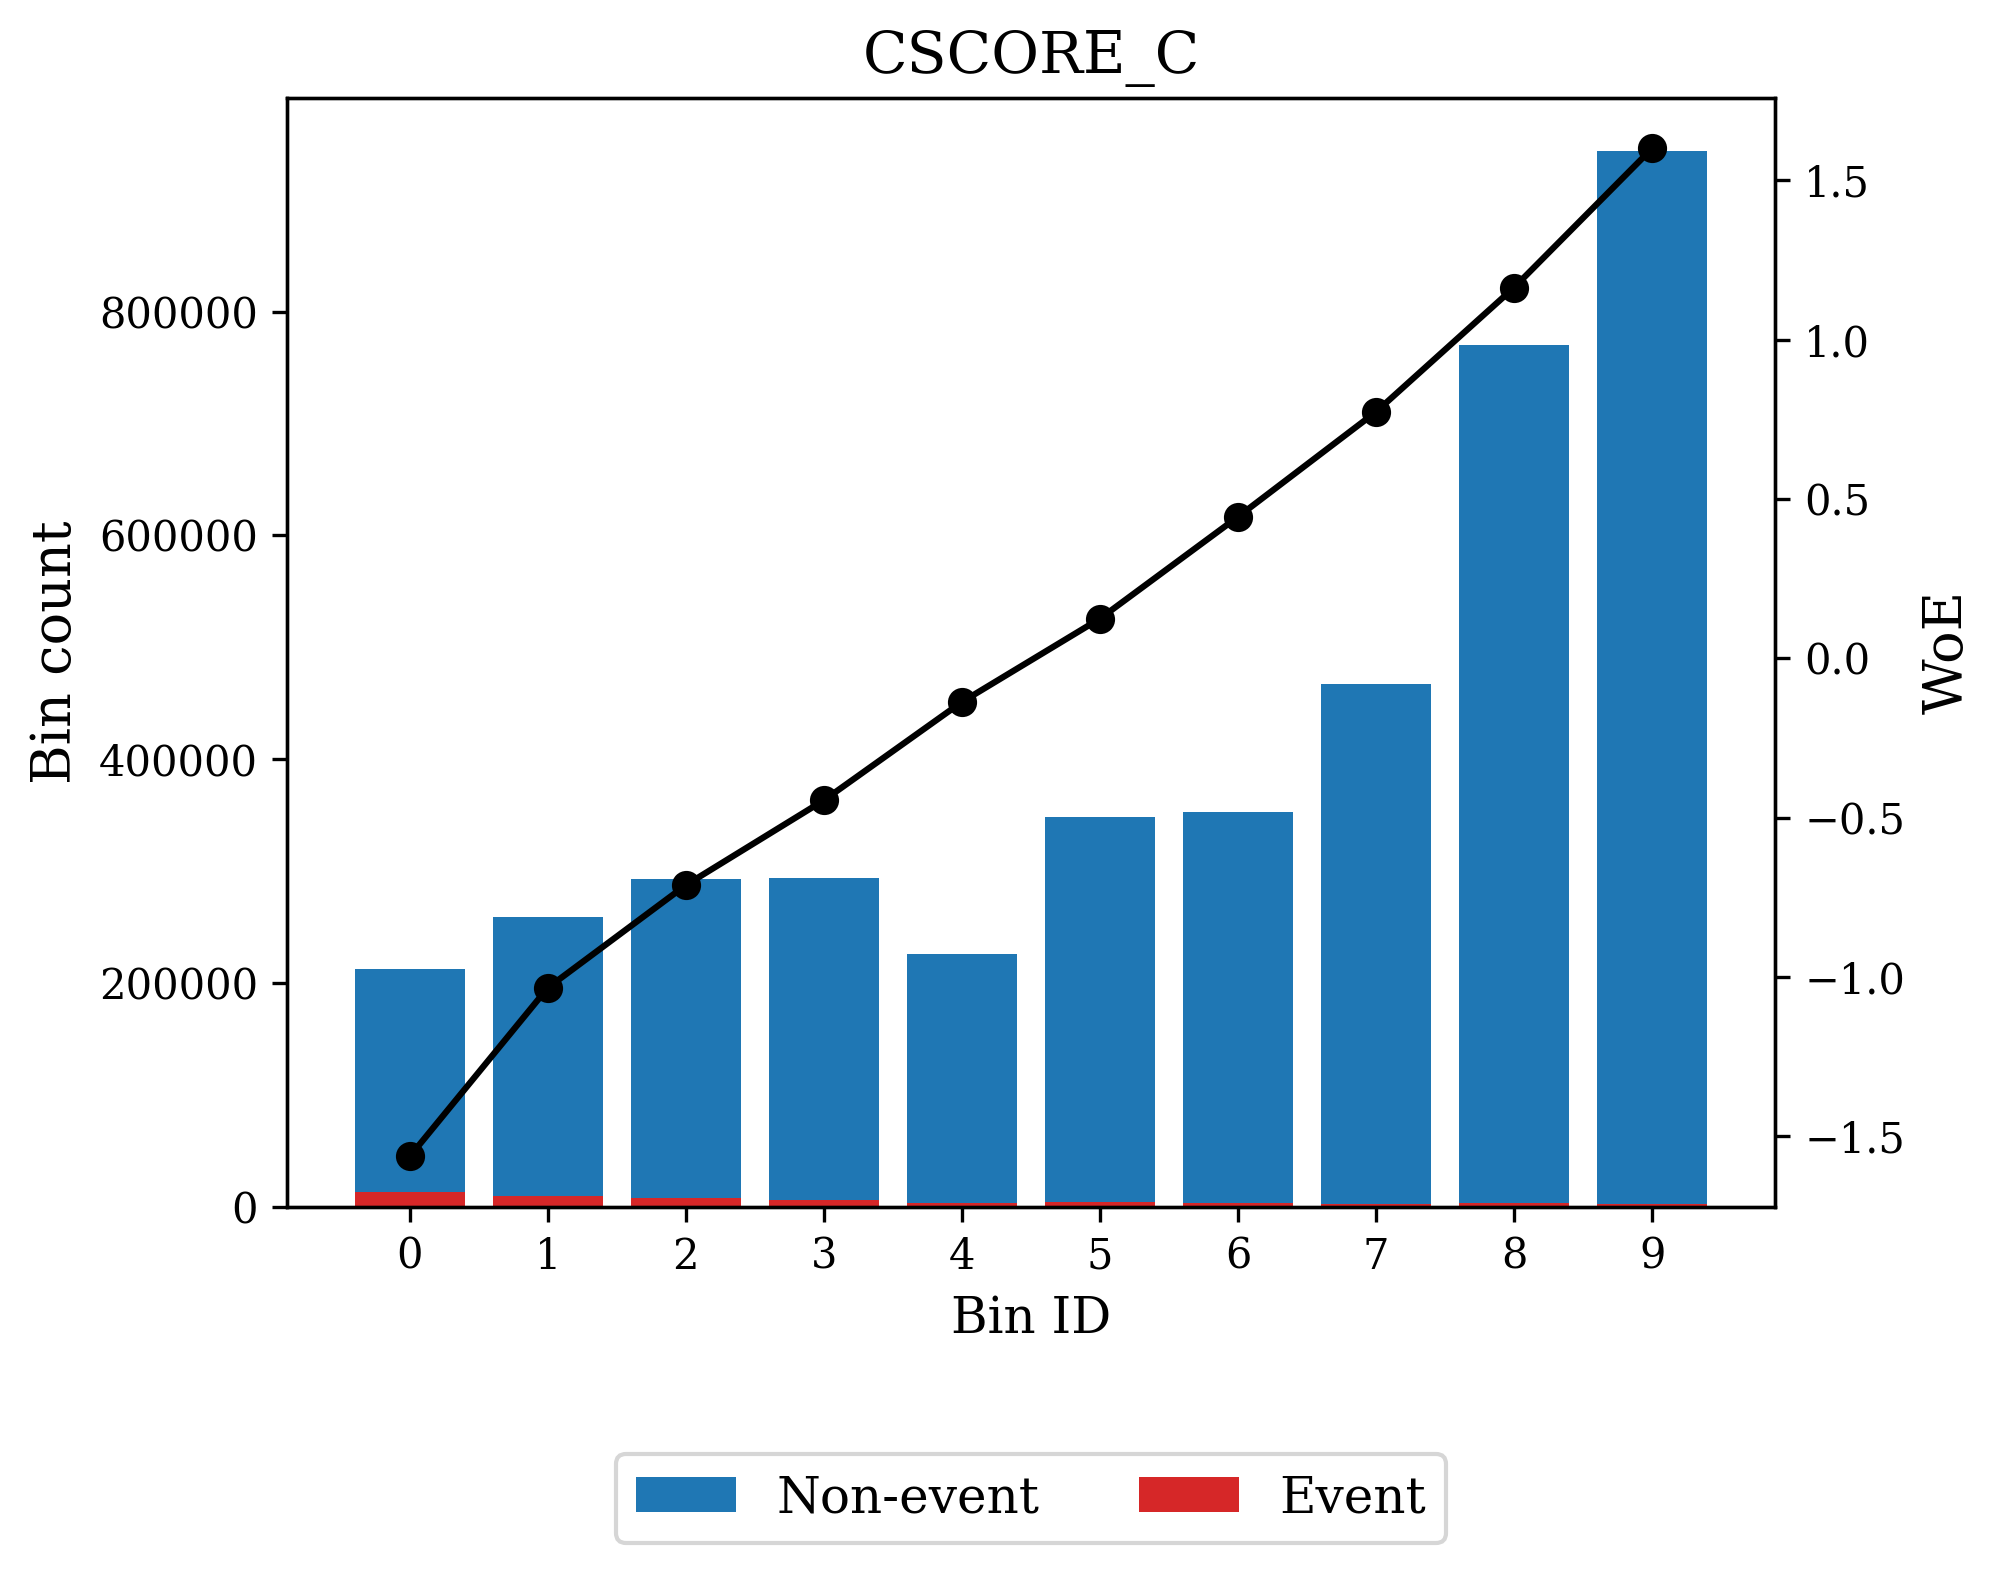


COLUMN: NUM_UNIT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",4167521,1.0,4111203,56318,0.013514,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,4167521,1.0,4111203,56318,0.013514,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


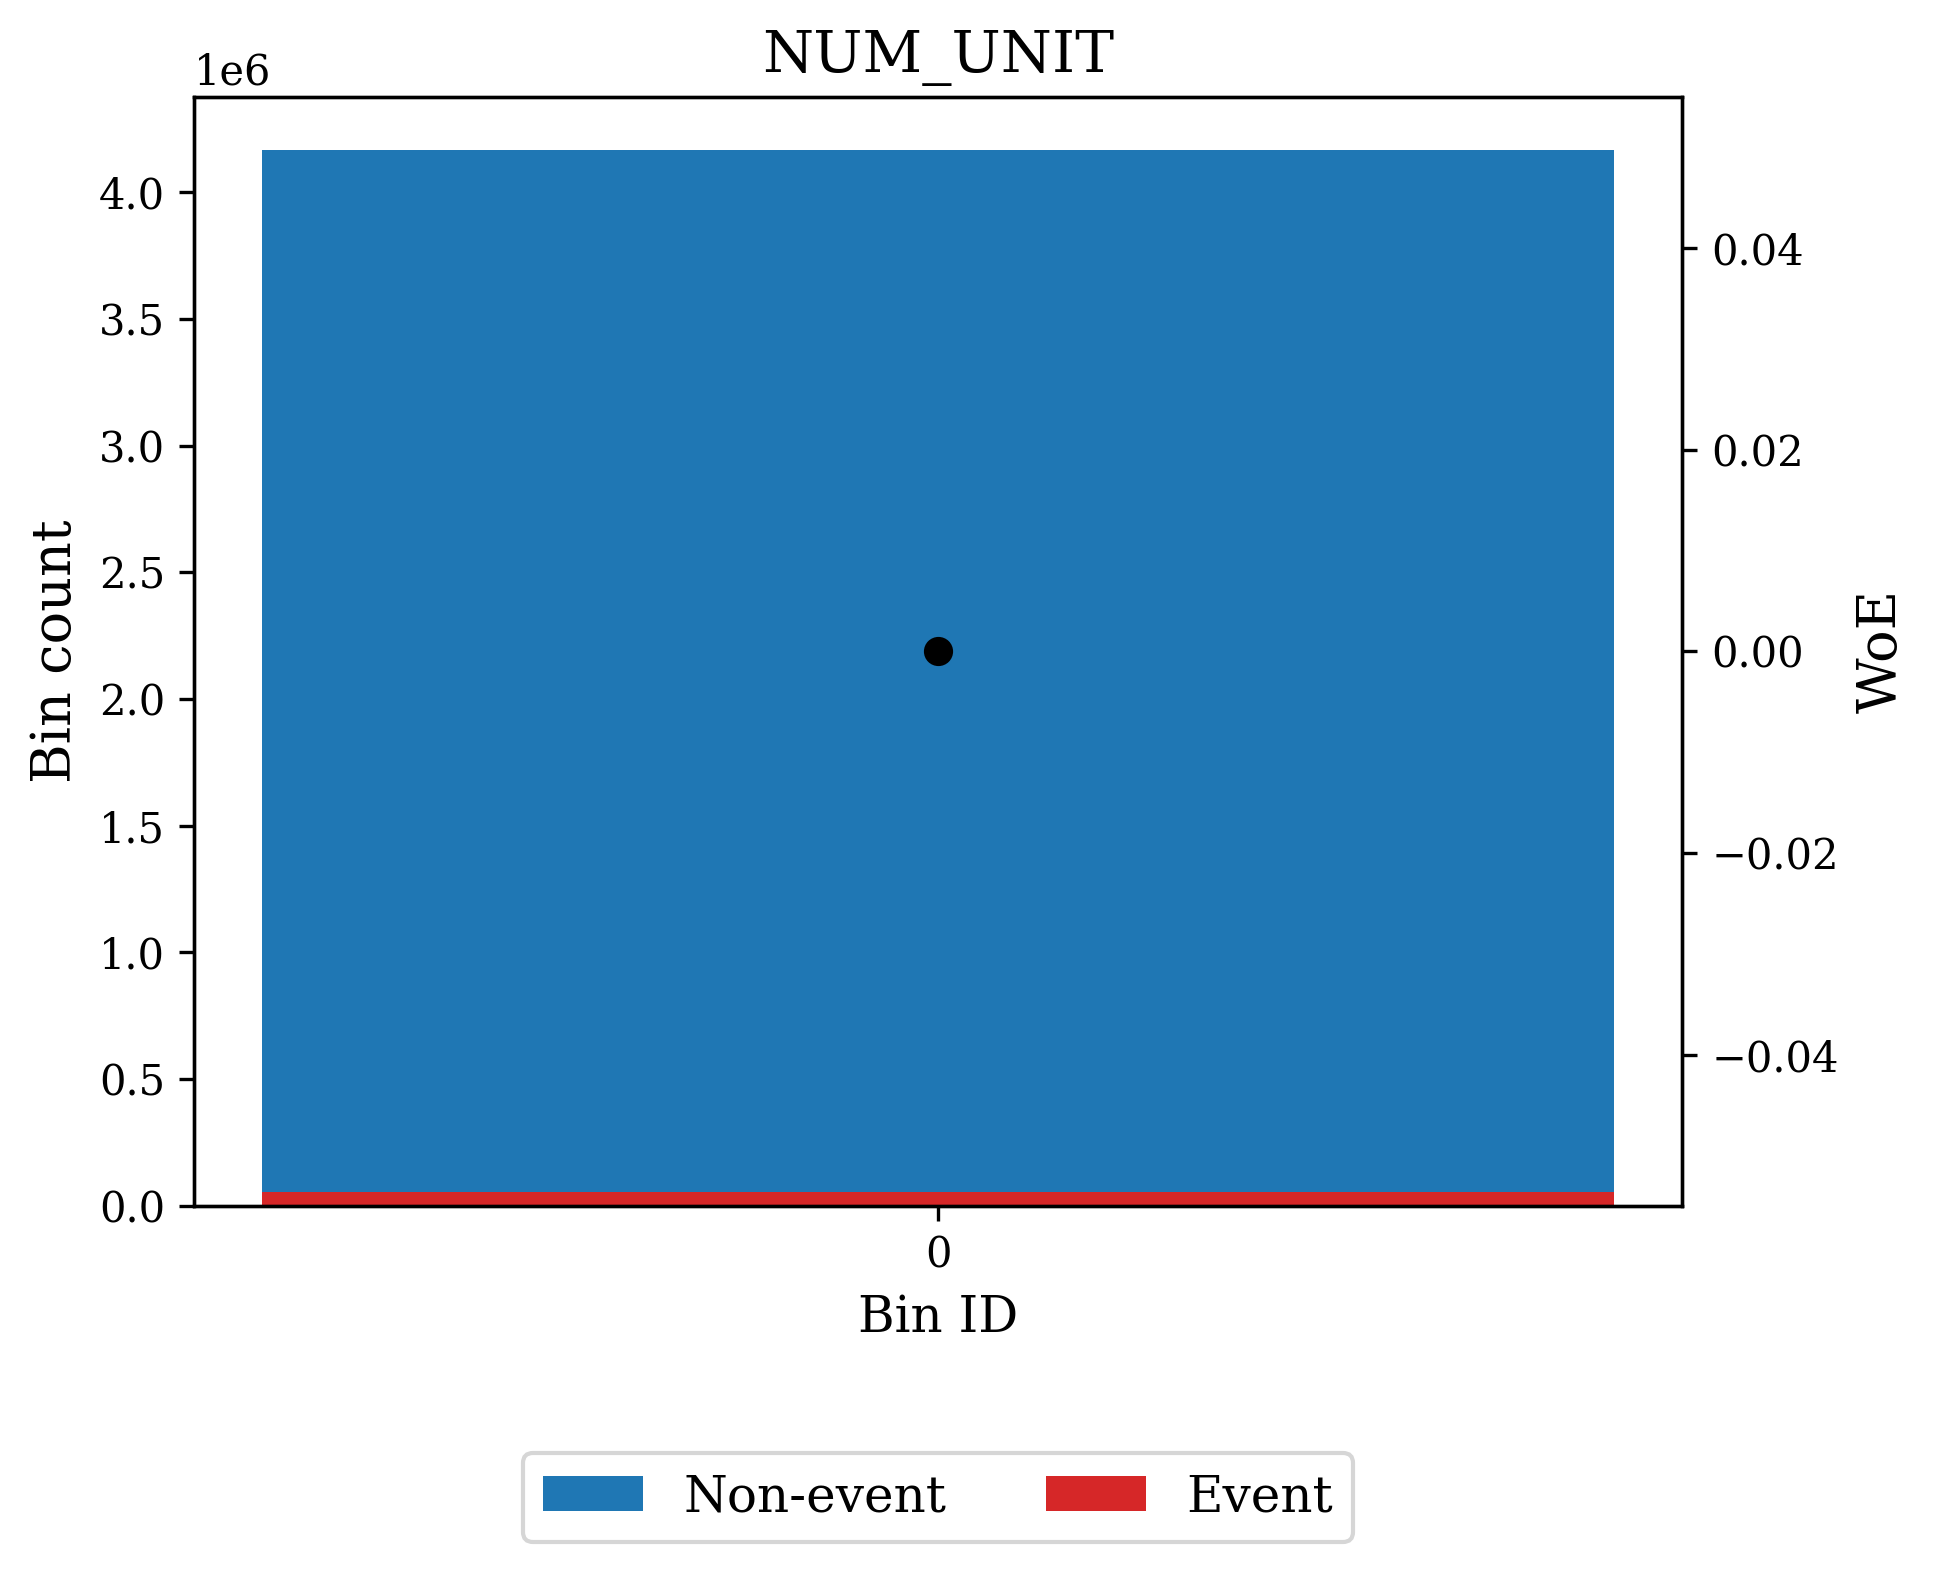


COLUMN: MI_PCT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.50)",3371063,0.808889,3336815,34248,0.010159,0.288687,0.058754,0.007319
1,"[11.50, 29.00)",417410,0.100158,407060,10350,0.024796,-0.618483,0.052426,0.006451
2,"[29.00, inf)",379048,0.090953,367328,11720,0.030920,-0.845498,0.100408,0.012190
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,4167521,1.000000,4111203,56318,0.013514,,0.211588,0.025960


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.20770605
    IV (Jeffrey)             0.21158790
    JS (Jensen-Shannon)      0.02595963
    Hellinger                0.02620039
    Triangular               0.10199541
    KS                       0.20352138
    HHI                      0.67260587
    HHI (normalized)         0.59075733
    Cramer's V               0.06087733
    Quality score            0.31270516

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1  6839.482123 0.000000e+00  0.000000e+00       1.0
        1      2   276.503956 4.339717e-62 1.303034e-100       1.0

None


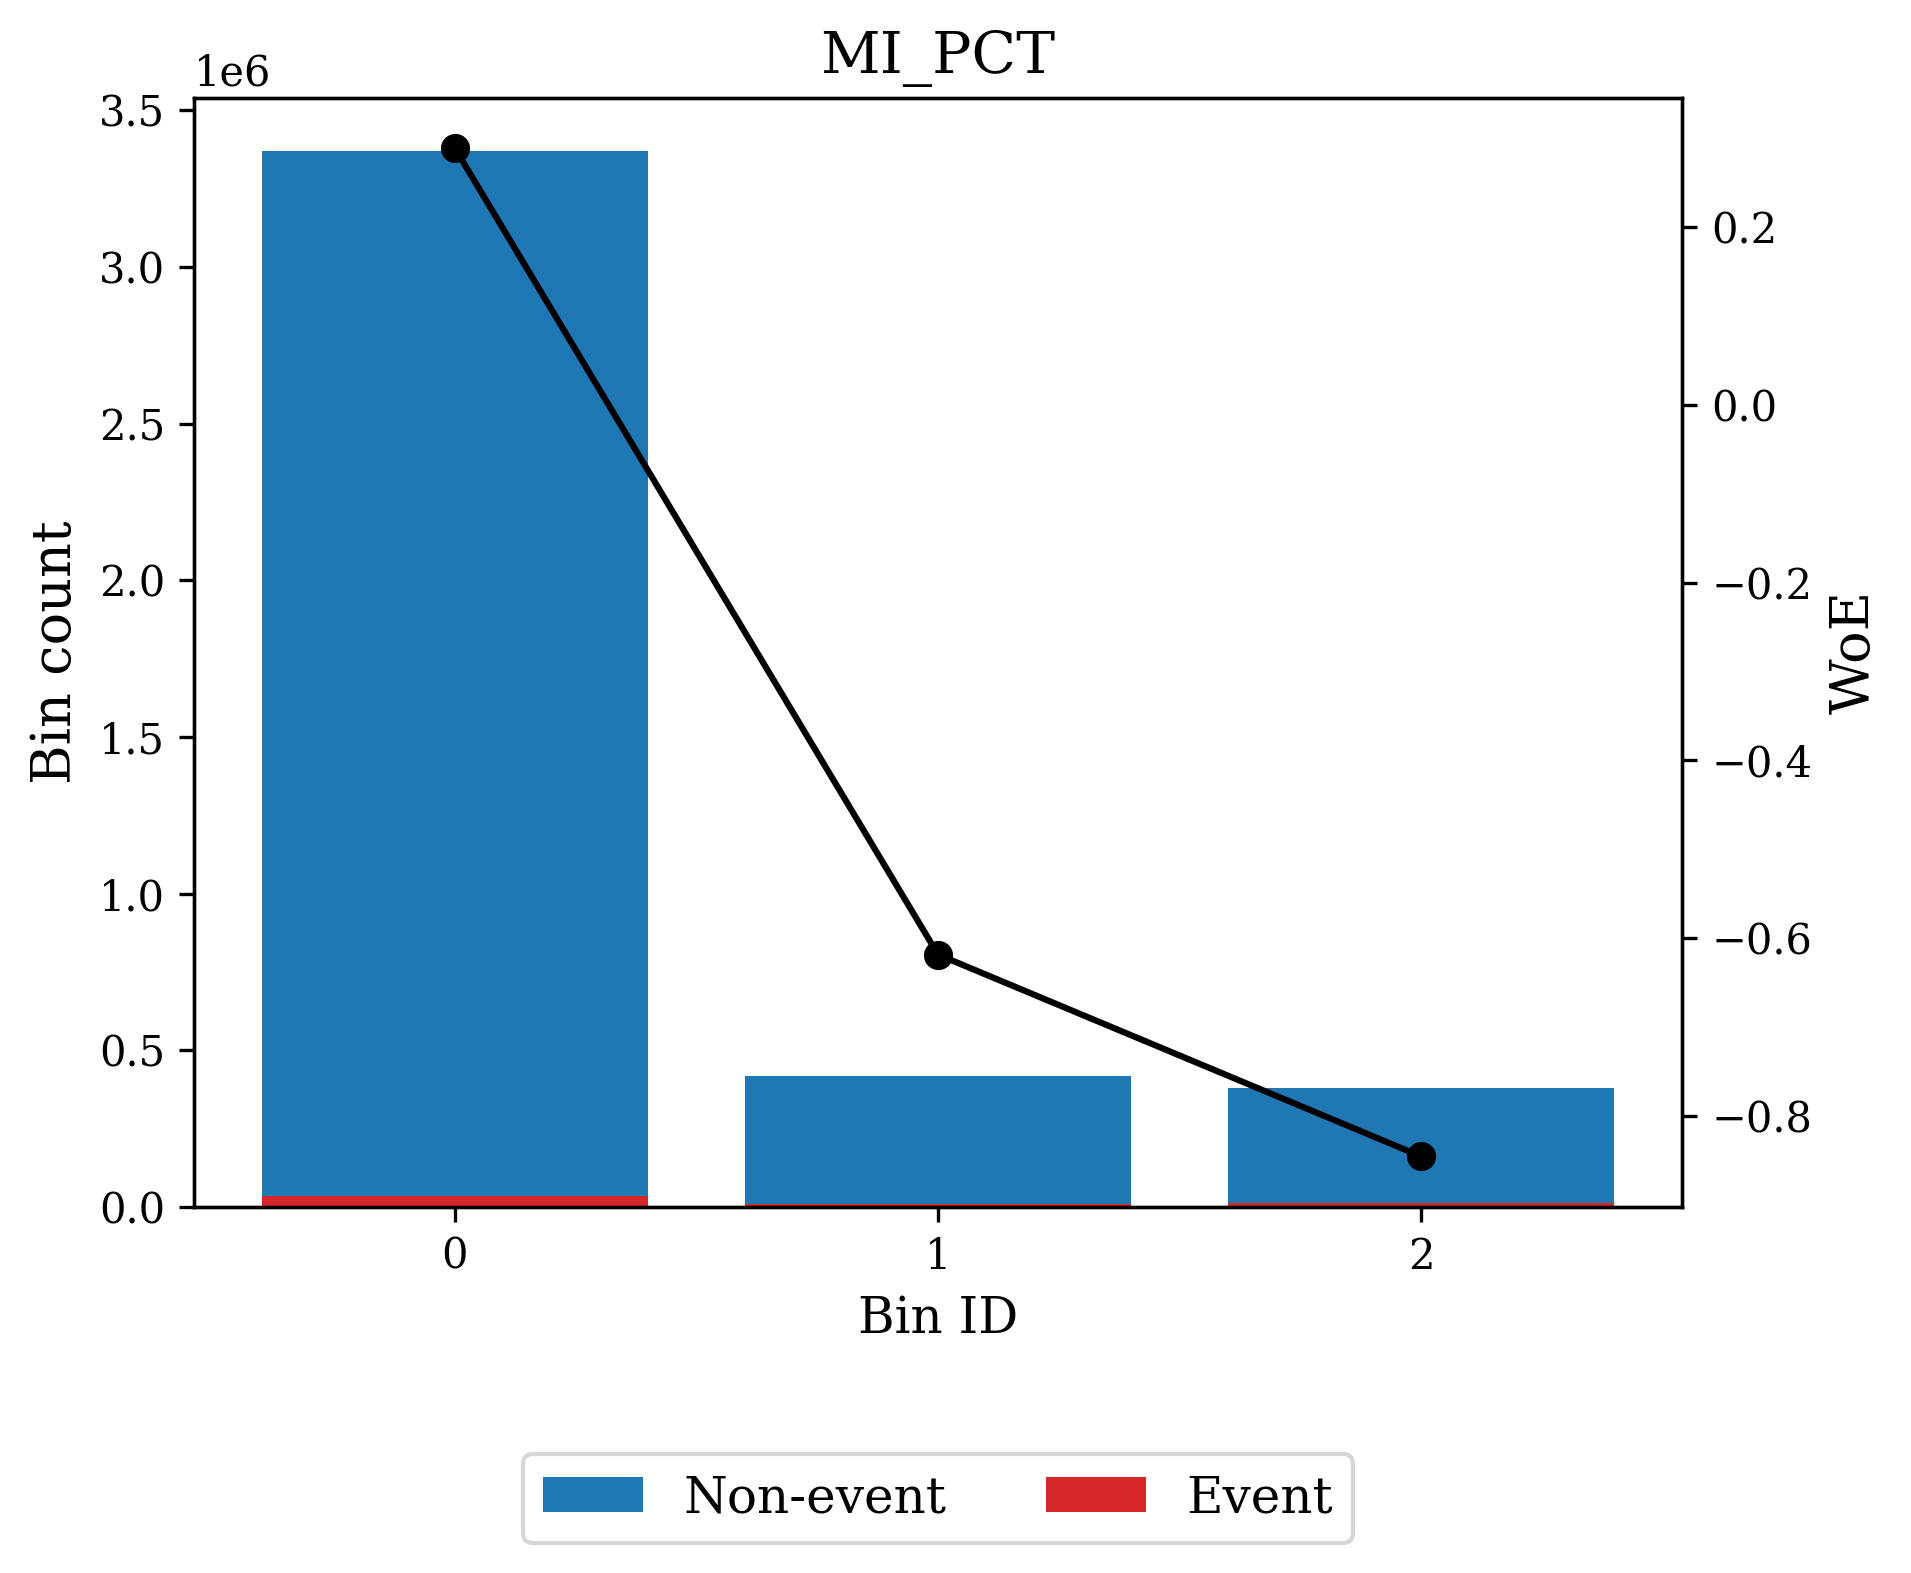

In [12]:

for col in NUMERICAL_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp", monotonic_trend="auto_asc_desc", max_n_bins=10)
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    iv_per_col[col] = optb.binning_table.iv
    optb.binning_table.plot(metric="woe",add_special=False,add_missing=False)
    opt_bin_data[col] = optb.transform(processed_df[col], metric="woe")
    print()

In [13]:
opt_bin_data

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,NUM_UNIT,MI_PCT,DLQ_90_FLAG,PUR,PRO,MI,OCC
0,1.217139,-0.165662,0.967181,0.212172,-0.291738,-0.481921,1.442647,1.163952,0.173393,0.0,0.288687,0,0.500898,-0.026343,0.0,-0.040169
1,0.662518,-0.165662,-0.218505,-0.131503,0.488985,0.072264,1.209478,1.163952,-0.631907,0.0,0.288687,0,-0.445660,-0.026343,0.0,-0.040169
3,0.466589,-0.165662,-0.218505,-0.452518,-0.291738,-0.068873,1.442647,1.600739,-0.631907,0.0,-0.845498,0,-0.445660,-0.026343,0.0,-0.040169
4,0.662518,-0.165662,-0.218505,1.279397,0.488985,0.313341,1.442647,-1.034337,0.173393,0.0,0.288687,0,0.500898,-0.026343,0.0,-0.040169
5,0.870771,-0.165662,-0.218505,0.354753,-0.291738,0.072264,0.809140,0.444237,0.173393,0.0,0.288687,0,0.500898,-0.026343,0.0,-0.040169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782086,-1.071865,0.072077,-0.218505,-0.009021,0.488985,0.313341,-0.075048,-0.445715,0.173393,0.0,0.288687,0,-0.004745,-0.026343,0.0,0.582669
4782088,-0.014864,-0.165662,-0.218505,-0.452518,-0.291738,-0.068873,-0.075048,-0.137061,-0.631907,0.0,-0.618483,0,-0.445660,0.150498,0.0,-0.040169
4782089,0.870771,0.072077,0.967181,-0.009021,0.488985,0.313341,0.809140,-0.445715,0.173393,0.0,0.288687,0,-0.004745,-0.026343,0.0,-0.040169
4782090,0.870771,0.062628,0.967181,0.808436,0.488985,-0.394401,0.333164,-0.712051,0.173393,0.0,0.288687,0,-0.004745,0.015821,0.0,-0.040169


# Model fitting

In [14]:
iv_per_col

{'PUR': 0.16515552451308374,
 'PRO': 0.0024662647905441064,
 'OCC': 0.02336014736643598,
 'MI': 0.0,
 'FTHB_FLAG': 0.10858228082690541,
 'ORIG_RATE': 0.38092958666120486,
 'ORIG_AMOUNT': 0.009404151755673192,
 'ORIG_TERM': 0.1977022514624262,
 'OLTV': 0.3538532475608748,
 'NUM_BO': 0.14098479304385608,
 'DTI': 0.2750449380053926,
 'CSCORE_B': 1.0573156488569124,
 'CSCORE_C': 0.9734647791314834,
 'NUM_UNIT': 0.0,
 'MI_PCT': 0.21158790081687318}

# 3 factor model
If we only accept predictors with an IV of > 0.3, we select ORIG_RATE, CSCORE_B, and OLTV

In [15]:
X_3factor, Y_3factor = opt_bin_data[["ORIG_RATE","CSCORE_B","OLTV"]], opt_bin_data["DLQ_90_FLAG"]
train_split = 0.7
X_3f_train, X_3f_test = X_3factor[:int(train_split*len(X_3factor))], X_3factor[int(train_split*len(X_3factor)):]
Y_3f_train, Y_3f_test = Y_3factor[:int(train_split*len(X_3factor))], Y_3factor[int(train_split*len(X_3factor)):]

In [16]:
def fit_logistic_regression(
    train: list[pd.DataFrame, pd.DataFrame],
    test: list[pd.DataFrame, pd.DataFrame],
    model_config: dict = {}
):
    logistic_model = linear_model.LogisticRegression(
        C = model_config.get("C", 1),
        solver=model_config.get("solver", "liblinear"),
        random_state=model_config.get("random_state", 0),
        class_weight=model_config.get("class_weight", None)
    )
    logistic_model.fit(train[0], train[1])

    print("Training accuracy:", logistic_model.score(train[0], train[1]))
    print("Testing accuracy:", logistic_model.score(test[0], test[1]))
    print(
        classification_report(
            y_pred=logistic_model.predict(test[0]),
            y_true=test[1]
        )
    )
    # Training AUC
    fpr, tpr, thresholds = metrics.roc_curve(train[1], logistic_model.predict(train[0]), pos_label=1)
    print("Training AUC:", metrics.auc(fpr, tpr))

    # Testing AUC
    fpr, tpr, thresholds = metrics.roc_curve(test[1], logistic_model.predict(test[0]), pos_label=1)
    print("Testing AUC:", metrics.auc(fpr, tpr))
    return logistic_model

In [17]:
woe_model = fit_logistic_regression(
    [X_3f_train, Y_3f_train],
    [X_3f_test, Y_3f_test]
)

Training accuracy: 0.9867368877139676
Testing accuracy: 0.9859020985285425


/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1232631
           1       0.00      0.00      0.00     17626

    accuracy                           0.99   1250257
   macro avg       0.49      0.50      0.50   1250257
weighted avg       0.97      0.99      0.98   1250257

Training AUC: 0.5
Testing AUC: 0.5


In [18]:
# Weight Balanced
woe_2f_model = fit_logistic_regression(
    [X_3f_train, Y_3f_train],
    [X_3f_test, Y_3f_test],
    model_config={
        "class_weight": {
            0 :  len(Y_3f_train)/(2*(len(Y_3f_train)-sum(Y_3f_train))),
            1 :  len(Y_3f_train)/(2* sum(Y_3f_train))
        }
    }
)
pickle.dump(woe_2f_model, open("log_reg_3f_woe.pkl", 'wb'))

Training accuracy: 0.7061342408503309
Testing accuracy: 0.6498487910885522
              precision    recall  f1-score   support

           0       1.00      0.65      0.78   1232631
           1       0.03      0.81      0.06     17626

    accuracy                           0.65   1250257
   macro avg       0.51      0.73      0.42   1250257
weighted avg       0.98      0.65      0.77   1250257

Training AUC: 0.73065355689125
Testing AUC: 0.7309027548807583


In [19]:
oversample = SMOTE()
X_3f_train_smote, Y_3f_train_smote = oversample.fit_resample(X_3f_train, Y_3f_train)
complete_model = fit_logistic_regression(
    [X_3f_train_smote, Y_3f_train_smote],
    [X_3f_test, Y_3f_test],
    # model_config={"C" : 100,}
)

Training accuracy: 0.730660897139276
Testing accuracy: 0.6498487910885522
              precision    recall  f1-score   support

           0       1.00      0.65      0.78   1232631
           1       0.03      0.81      0.06     17626

    accuracy                           0.65   1250257
   macro avg       0.51      0.73      0.42   1250257
weighted avg       0.98      0.65      0.77   1250257

Training AUC: 0.730660897139276
Testing AUC: 0.7309027548807583


# Testing WOE generated on SVM, and XGBoost

In [20]:
# XGBoost
weight_deliquent =  len(Y_3f_train)/(2* sum(Y_3f_train))
scaler_weight_xgb_3f = XGBClassifier(scale_pos_weight=weight_deliquent, eval_metric='auc')
scaler_weight_xgb_3f.fit(X_3f_train, Y_3f_train)
y_pred = scaler_weight_xgb_3f.predict(X_3f_test)
accuracy = accuracy_score(Y_3f_test, y_pred)
roc_auc = roc_auc_score(Y_3f_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report")
print(classification_report(Y_3f_test, y_pred))

pickle.dump(scaler_weight_xgb_3f, open("xgboost_3f_woe.pkl", 'wb'))

Accuracy: 0.8094359799625197
AUC-ROC: 0.7153979767938796
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.81      0.89   1232631
           1       0.04      0.62      0.08     17626

    accuracy                           0.81   1250257
   macro avg       0.52      0.72      0.49   1250257
weighted avg       0.98      0.81      0.88   1250257



In [21]:
# SVM
svm_model_3f = LinearSVC(random_state=99, max_iter=8192, class_weight='balanced')
svm_model_3f.fit(X_3f_train, Y_3f_train)

y_pred = svm_model_3f.predict(X_3f_test)
accuracy = accuracy_score(Y_3f_test, y_pred)
roc_auc = roc_auc_score(Y_3f_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report")
print(classification_report(Y_3f_test, y_pred))
pickle.dump(svm_model_3f, open("linear_svm_3f_woe.pkl", 'wb'))

Accuracy: 0.6487362198332023
AUC-ROC: 0.7305901685858778
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.65      0.78   1232631
           1       0.03      0.81      0.06     17626

    accuracy                           0.65   1250257
   macro avg       0.51      0.73      0.42   1250257
weighted avg       0.98      0.65      0.77   1250257



In [31]:
min(processed_df.rename(columns=columns_rename_temp)["Original Rate"])

1.5

In [35]:
max(processed_df["OLTV"])

97.0

COLUMN: Original Rate
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.45)",524327,0.125813,522209,2118,0.004039,1.217139,0.108828,0.012821
1,"[2.45, 2.59)",271135,0.065059,269589,1546,0.005702,0.870771,0.033196,0.004023
2,"[2.59, 2.64)",303586,0.072846,301457,2129,0.007013,0.662518,0.023534,0.002889
3,"[2.64, 2.81)",540282,0.129641,535680,4602,0.008518,0.466589,0.022668,0.002808
4,"[2.81, 2.92)",614506,0.147451,607944,6562,0.010678,0.238331,0.007474,0.000932
5,"[2.92, 3.10)",565662,0.135731,557905,7757,0.013713,-0.014864,0.000030,0.000004
6,"[3.10, 3.15)",312993,0.075103,308318,4675,0.014936,-0.101554,0.000814,0.000102
7,"[3.15, 3.25)",400070,0.095997,392543,7527,0.018814,-0.336307,0.012837,0.001597
8,"[3.25, 3.56)",411265,0.098683,400469,10796,0.026251,-0.676996,0.063833,0.007830
9,"[3.56, inf)",223695,0.053676,215089,8606,0.038472,-1.071865,0.107715,0.012855


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.33902226
    IV (Jeffrey)             0.38092959
    JS (Jensen-Shannon)      0.04586137
    Hellinger                0.04671412
    Triangular               0.17715518
    KS                       0.24299975
    HHI                      0.10981499
    HHI (normalized)         0.02888908
    Cramer's V               0.07503797
    Quality score            0.96973128

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1   107.735010  3.072274e-25  1.069879e-43       1.0
        1      2    38.736822  4.849733e-10  5.955201e-12       1.0
        2      3    55.633406  8.732696e-14  5.848097e-16       1.0
        3      4   140.198594  2.408719e-32  6.016982e-45       1.0
        4      5   226.300909  3.82015

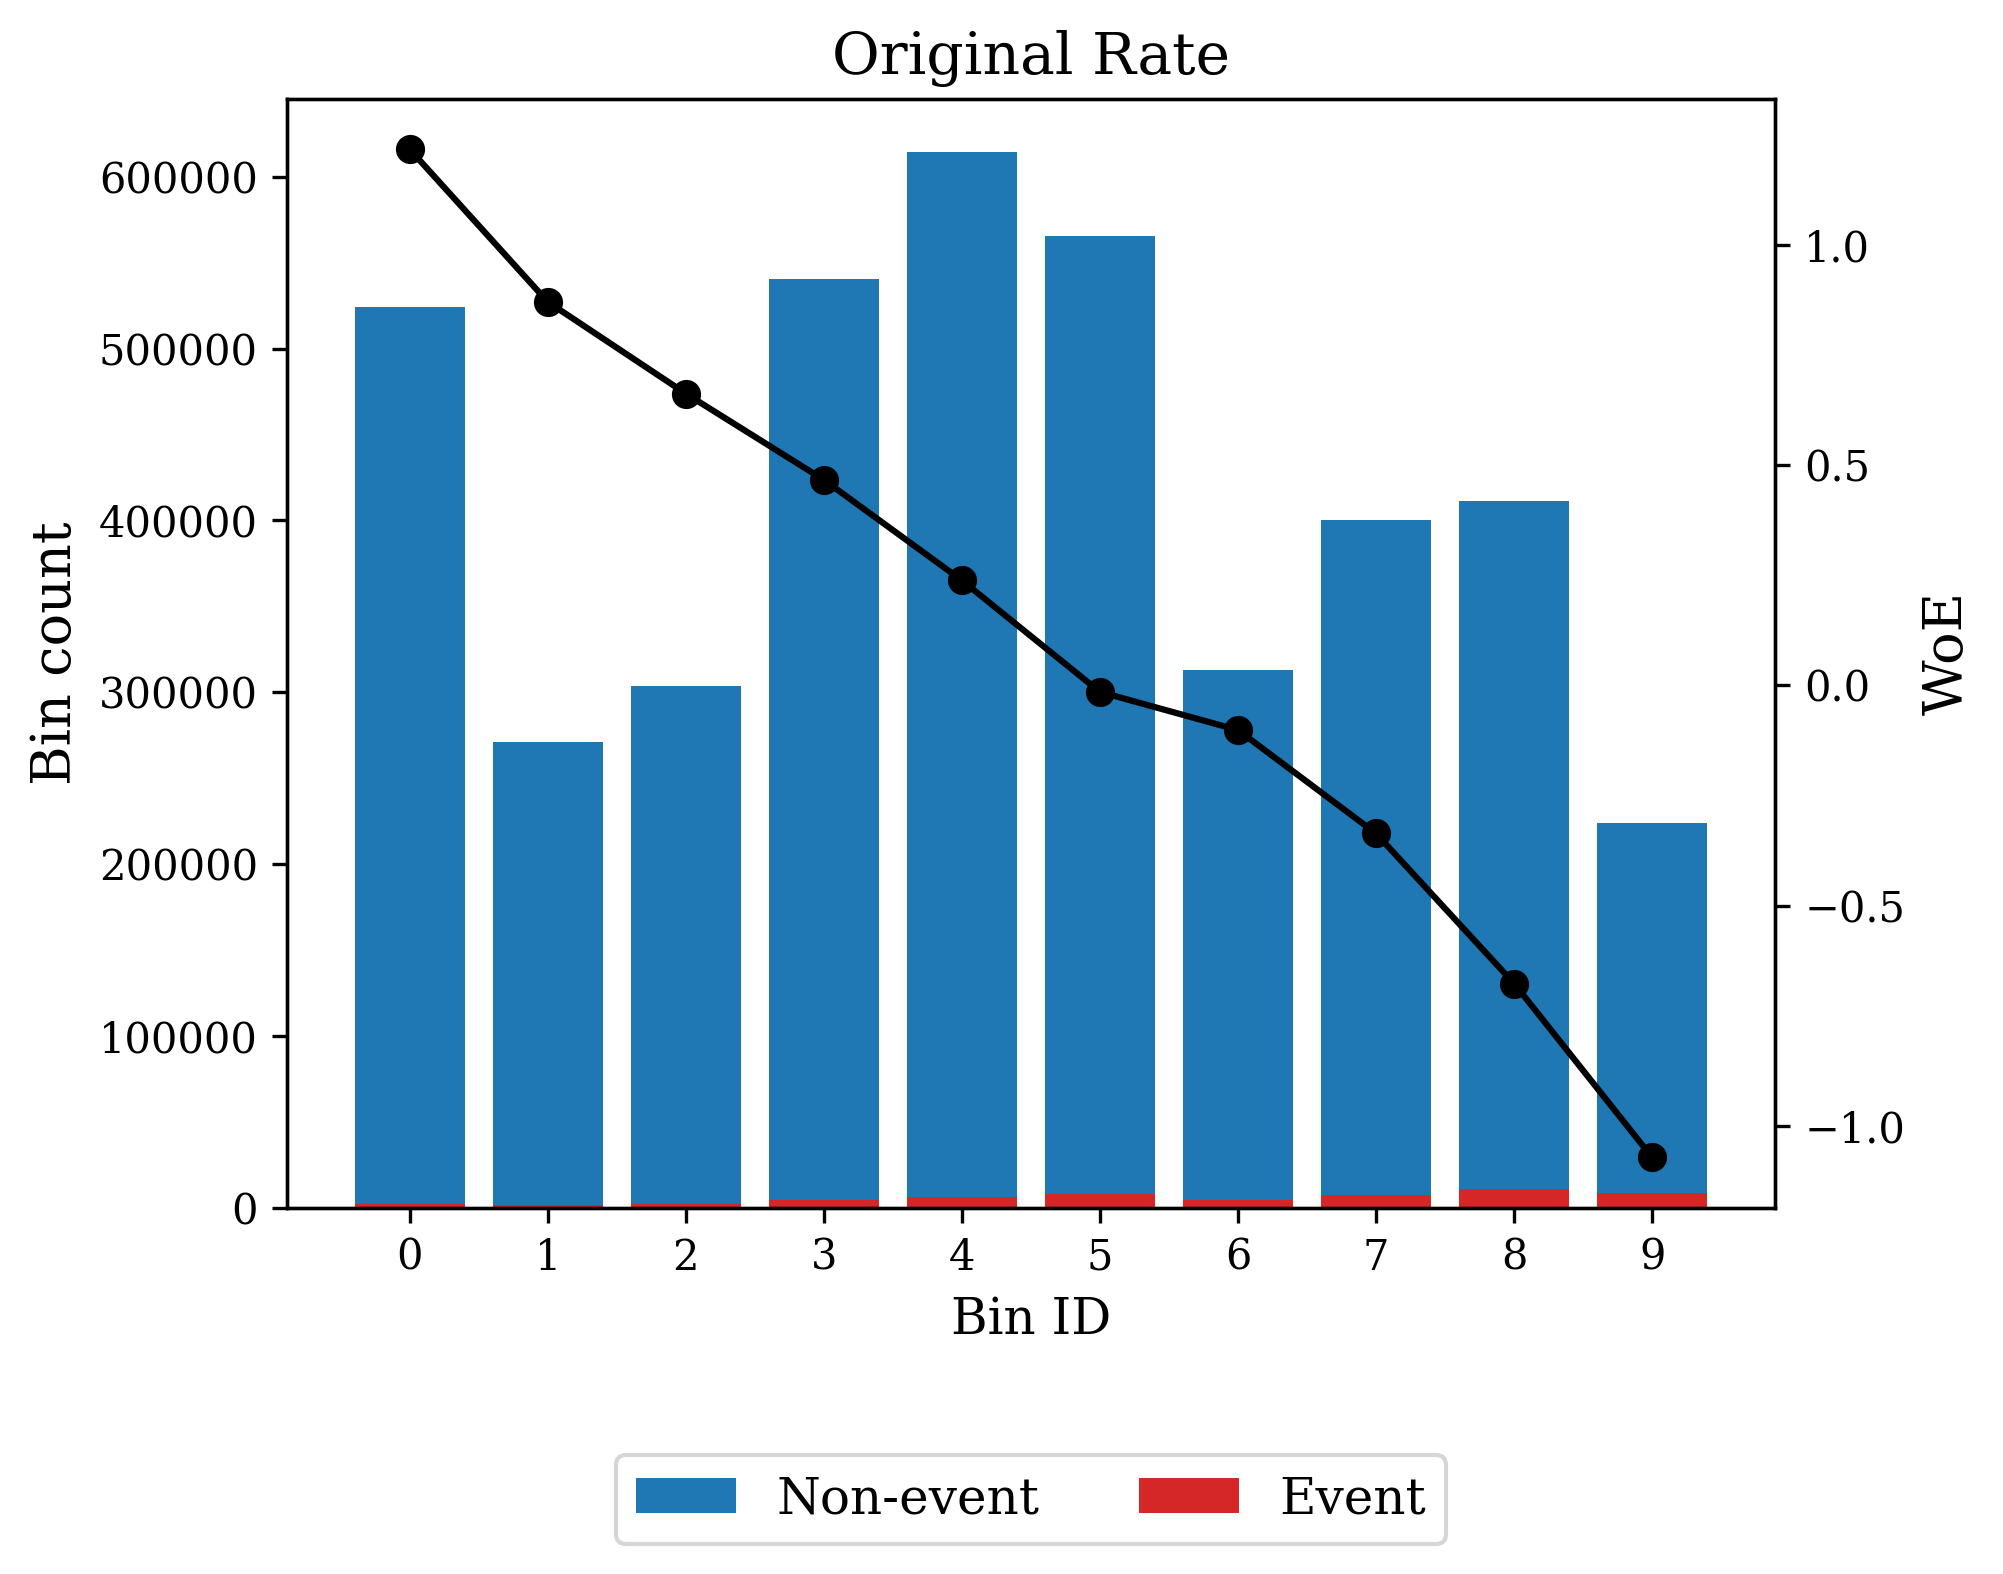


COLUMN: Credit Score
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 676.50)",209556,0.050283,196052,13504,0.064441,-1.615063,0.310244,0.035049
1,"[676.50, 697.50)",216602,0.051974,208171,8431,0.038924,-1.084012,0.107391,0.012803
2,"[697.50, 714.50)",253302,0.060780,245878,7424,0.029309,-0.790339,0.056917,0.006935
3,"[714.50, 736.50)",388986,0.093338,380642,8344,0.021451,-0.47014,0.026127,0.003236
4,"[736.50, 752.50)",375015,0.089985,369558,5457,0.014551,-0.075048,0.000526,0.000066
5,"[752.50, 766.50)",415769,0.099764,411727,4042,0.009722,0.333164,0.009454,0.001176
6,"[766.50, 784.50)",697928,0.167468,693697,4231,0.006062,0.80914,0.075741,0.009217
7,"[784.50, 792.50)",383009,0.091903,381450,1559,0.004070,1.209478,0.078738,0.009283
8,"[792.50, 803.50)",590410,0.141669,588505,1905,0.003227,1.442647,0.157711,0.018165
9,"[803.50, inf)",636944,0.152835,635523,1421,0.002231,1.812631,0.234466,0.025858


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.54482313
    IV (Jeffrey)             1.05731565
    JS (Jensen-Shannon)      0.12178754
    Hellinger                0.12667487
    Triangular               0.45388402
    KS                       0.42575630
    HHI                      0.11560666
    HHI (normalized)         0.03520727
    Cramer's V               0.13375329
    Quality score            0.11976366

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1420.484902 7.430863e-311       1.0 0.000000e+00
        1      2   331.087781  5.570169e-74       1.0 0.000000e+00
        2      3   395.586942  5.030544e-88       1.0 0.000000e+00
        3      4   512.376974 1.927771e-113       1.0 0.000000e+00
        4      5   387.531289  2.853139e-86

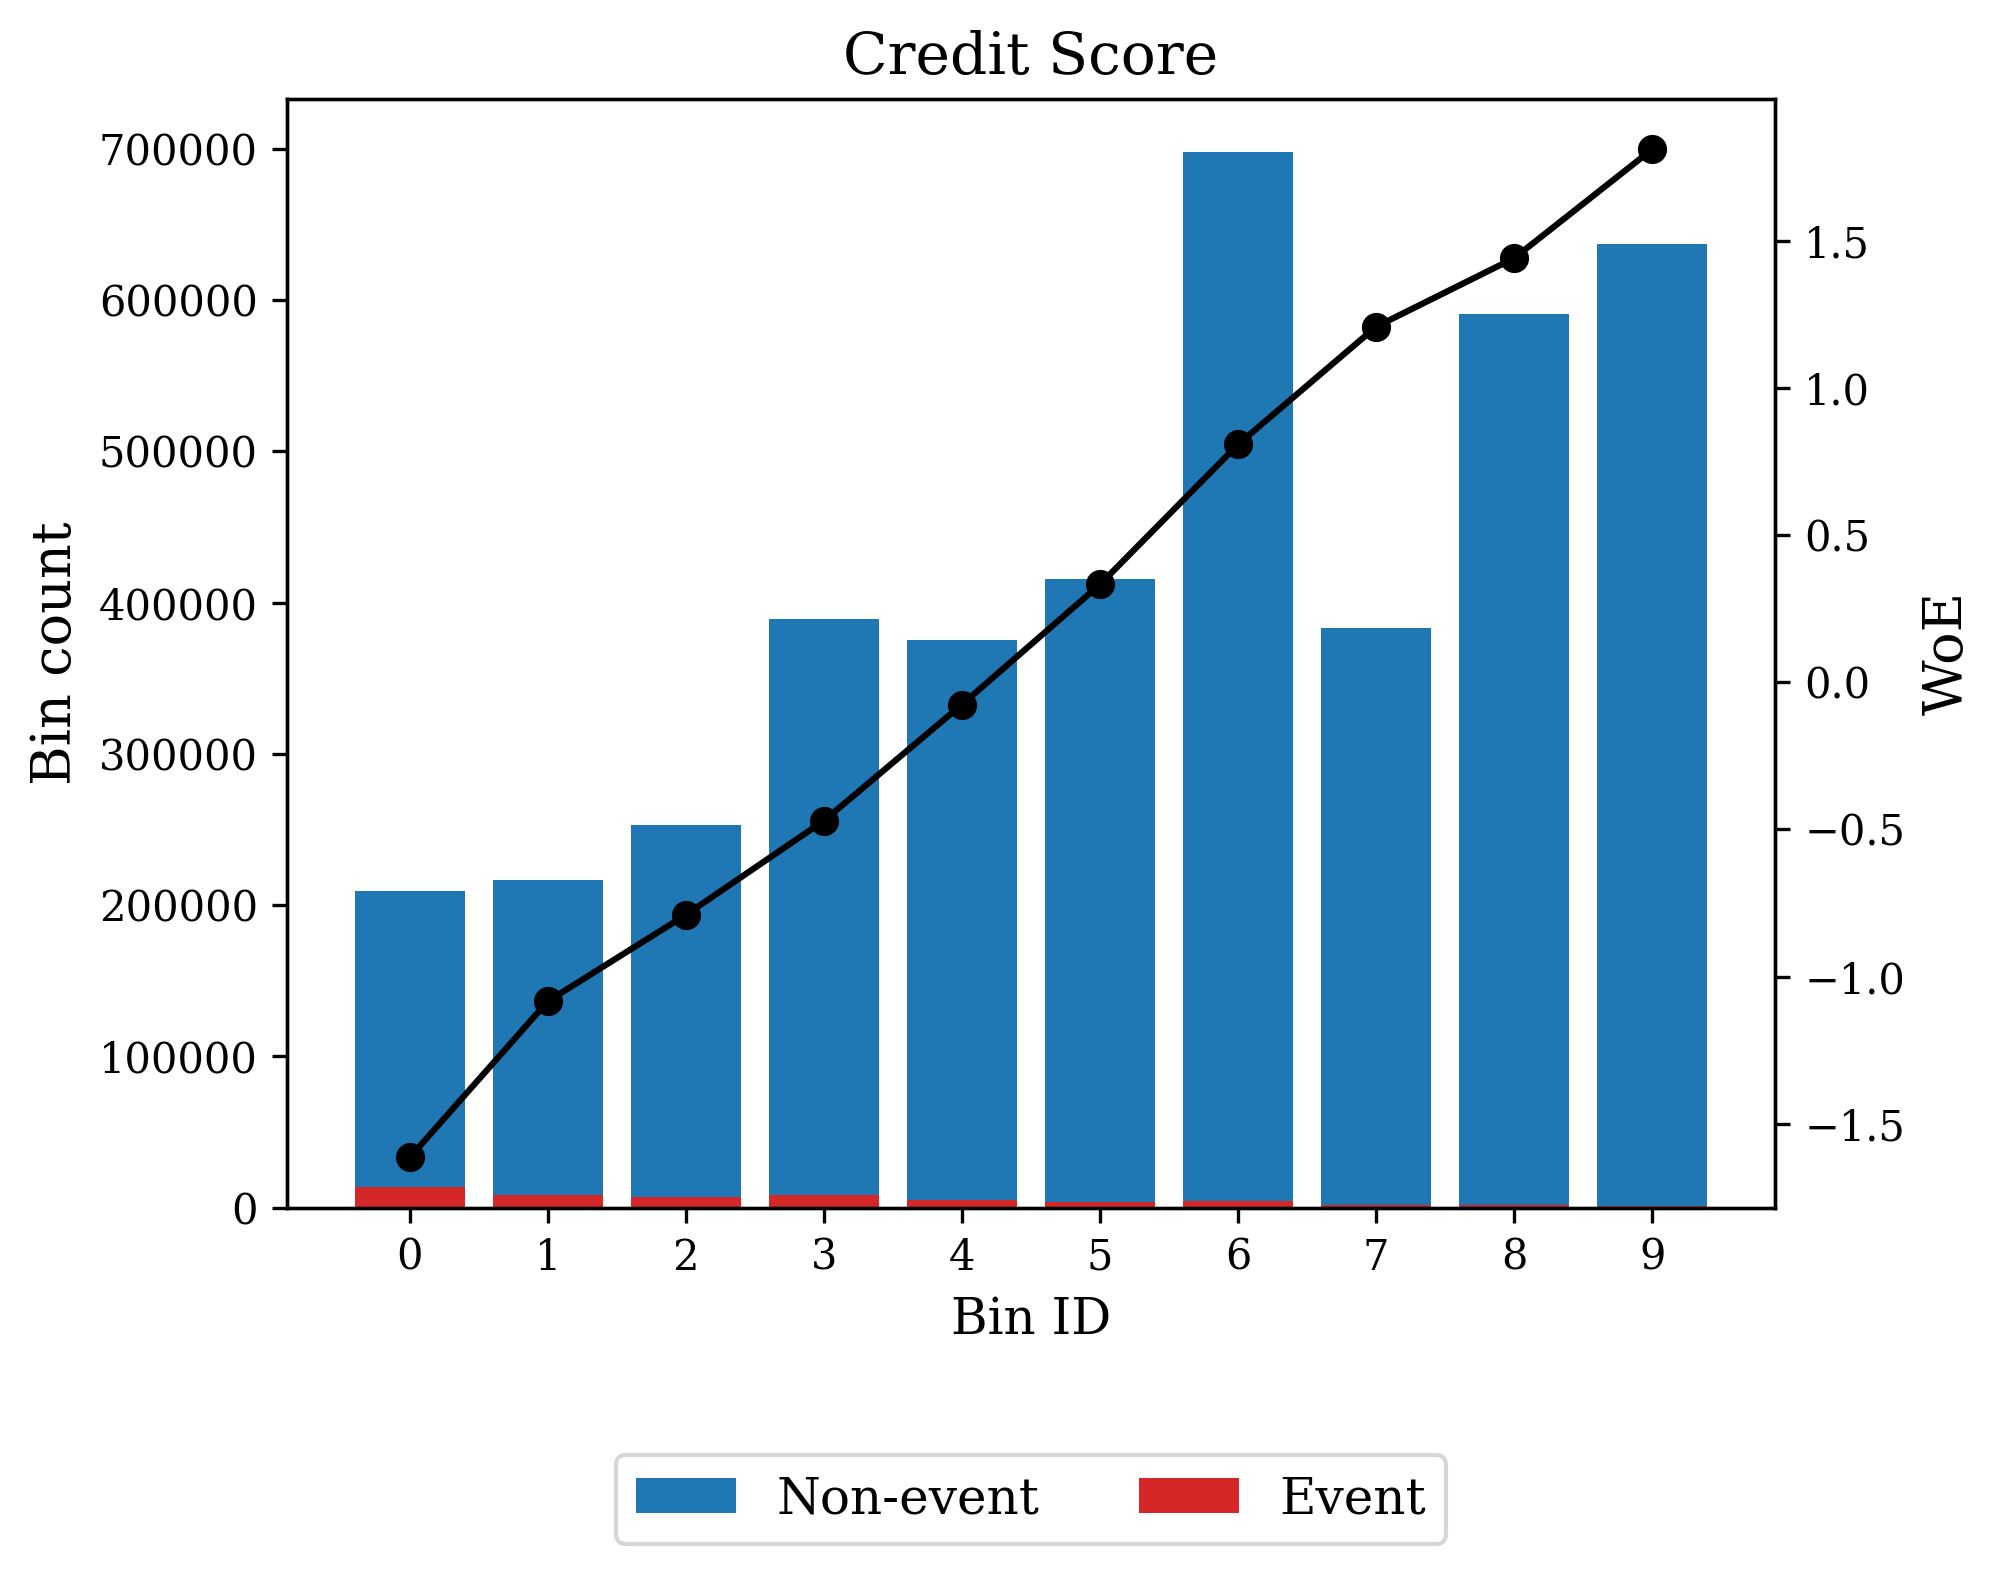


COLUMN: Original Loan to Value
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 35.50)",258918,0.062128,257935,983,0.003797,1.279397,0.057938,0.006785
1,"[35.50, 44.50)",277060,0.066481,275728,1332,0.004808,1.042277,0.045252,0.005414
2,"[44.50, 54.50)",470949,0.113005,468092,2857,0.006066,0.808436,0.051035,0.006211
3,"[54.50, 59.50)",332186,0.079708,329655,2531,0.007619,0.578975,0.020405,0.002516
4,"[59.50, 64.50)",343103,0.082328,339838,3265,0.009516,0.354753,0.008758,0.001089
5,"[64.50, 69.50)",330431,0.079287,326810,3621,0.010958,0.212172,0.003224,0.000402
6,"[69.50, 76.50)",642569,0.154185,633808,8761,0.013634,-0.009021,0.000013,0.000002
7,"[76.50, 84.50)",756263,0.181466,744629,11634,0.015384,-0.131503,0.003347,0.000418
8,"[84.50, 93.50)",307202,0.073713,300725,6477,0.021084,-0.452518,0.018942,0.002348
9,"[93.50, inf)",448840,0.107700,433983,14857,0.033101,-0.915923,0.144940,0.017510


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.32400730
    IV (Jeffrey)             0.35385325
    JS (Jensen-Shannon)      0.04269412
    Hellinger                0.04344305
    Triangular               0.16521518
    KS                       0.22695640
    HHI                      0.11420303
    HHI (normalized)         0.03367603
    Cramer's V               0.07139768
    Quality score            0.95514885

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1    31.813668  1.696944e-08  5.912011e-10       1.0
        1      2    49.639254  1.847794e-12  2.072119e-14       1.0
        2      3    70.478179  4.653859e-17  9.412835e-25       1.0
        3      4    71.366611  2.966499e-17  1.511519e-22       1.0
        4      5    34.603954  4.04084

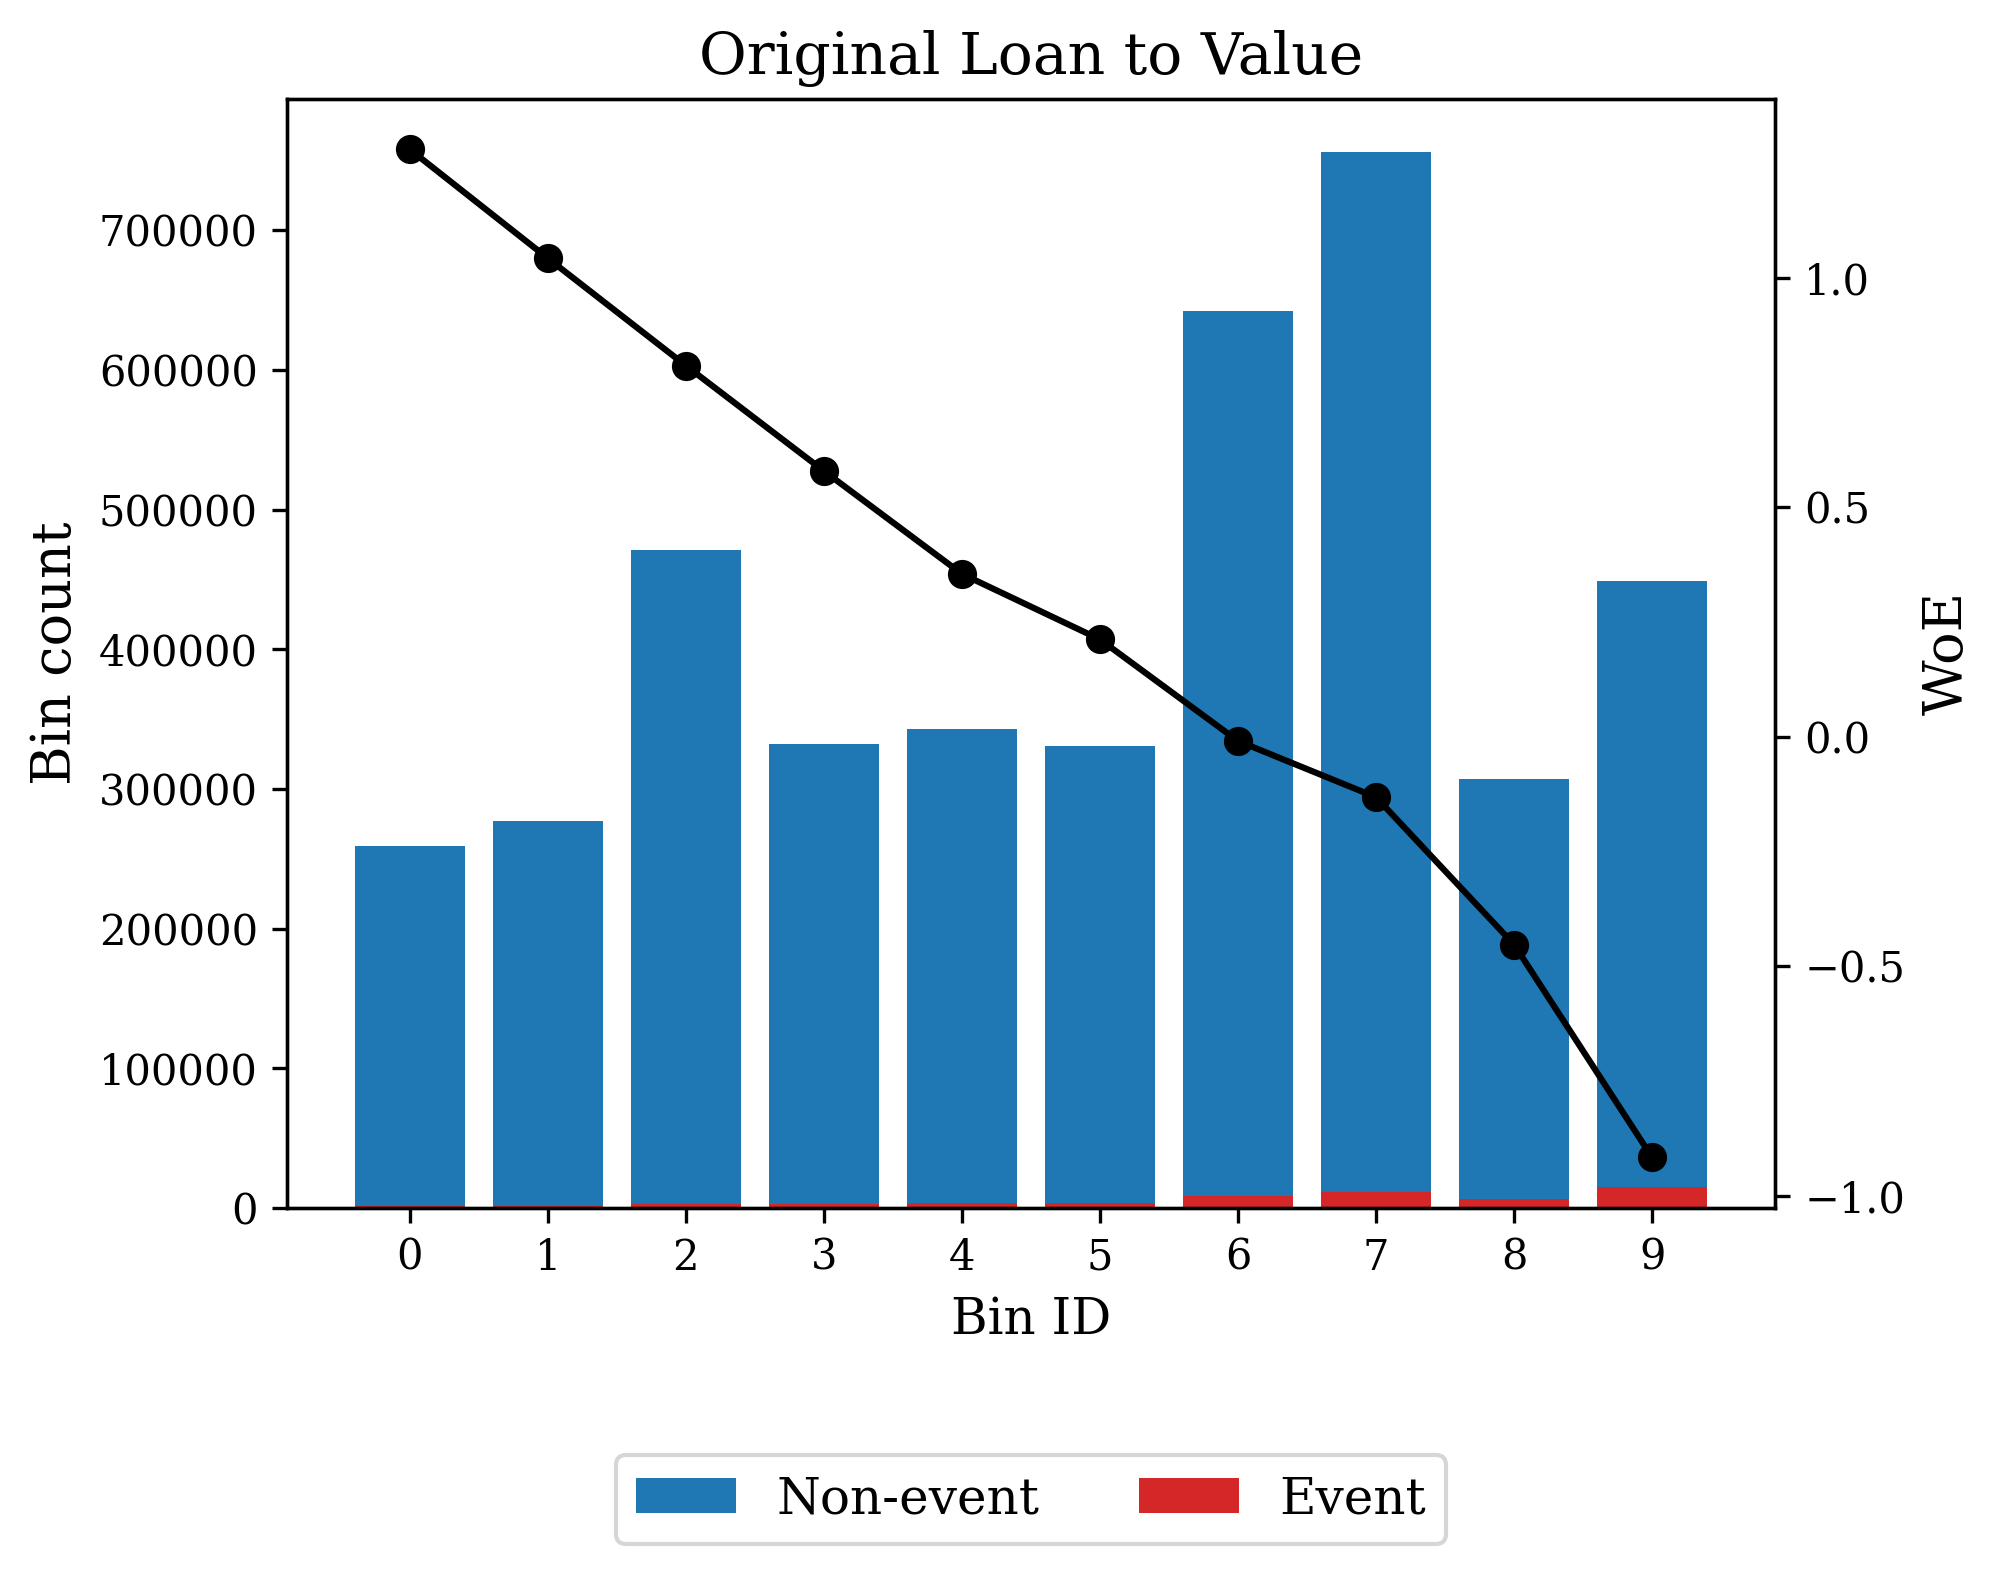

In [29]:
columns_rename_temp = {
    "ORIG_RATE" : "Original Rate",
    "CSCORE_B": "Credit Score",
    "OLTV": "Original Loan to Value"
}
temporary_df = processed_df.rename(columns=columns_rename_temp)
for _, col in columns_rename_temp.items():
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp", monotonic_trend="auto_asc_desc", max_n_bins=10)
   
    optb.fit(temporary_df[col], temporary_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    optb.binning_table.plot(metric="woe",add_special=False,add_missing=False)
    print()